# Projet - Apprentissage séquentielle


<div style="text-align: right"> 
ISUP, Master 2      

Janvier 2026

</div>

<div style="text-align: right"> 
Kaiwei HUANG,
Fei WANG,
Jiaxuan YU
</div>

# Table of contents
1. [介绍Introduction](#part1)
    - [导入与数据预处理Importation et prétraitement des données](#part1sec1)
    - [添加补充性特征Ajout des features complémentaires](#part1sec2)
        - [空气质量评估Évaluation de la qualité de l'air](#part1sec2-1)
        - [缺失数据插值Interpolation des données manquantes](#part1sec2-2)
    - [清洗Netoyage](#part1sec3)
    - [数据分析Analyse des données](#part1sec4)
    - [训练集-测试集划分Train-Test Split](#part1sec5)
2. [初步模型Premières Modèles](#part2)
    - [季节性自回归积分滑动平均模型SARIMA](#part2sec1)
    - [包含外生变量的季节性自回归积分滑动平均模型SARIMAX](#part2sec2)
3. [随机森林与BoostingRF et Boosting](#part3)
    - [随机森林Random forest](#part3sec1)
    - [提升法Boosting](#part3sec2)
    - [装袋法Bagging](#part3sec3)
4. [神经网络Réseaux neuroneaux](#part4)
    - [多层感知机MLP](#part4sec1)
    - [长短期记忆网络LSTM](#part4sec2)
    - [门控循环单元GRU](#part4sec3)
5. [总结Conclusion](#part5)

In [1]:
# Suppress warnings
import warnings
import sys
warnings.filterwarnings('ignore')
import os
# dataset
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import holidays
from statsmodels.tsa.stattools import acf, pacf
# plot
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
#Sarima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
#Random Forest,boosting,bagging
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
# Neural Networks
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import shutil
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import json

import optuna

#preprocessing analyse des données du model
import shap

# 介绍Introduction <a id="part1"></a>


我们的数据来源于UCI 空气质量数据库（[UCI Air Quality](https://archive.ics.uci.edu/dataset/360/air+quality)）。该数据集记录了2004年03月至2005年02月期间，意大利某地区空气中多种化学分子的每小时浓度，同时还包含温度和湿度的测量数据。由于传感器的灵敏度问题，某些缺失数据被记录为-200。

本项目的目标是研究与时间序列数据相关的统计学习模型，并努力开发出一个优秀的空气质量预测模型。

Nos données proviennent de la base de données [UCI Air Quality](https://archive.ics.uci.edu/dataset/360/air+quality). Cet ensemble de données enregistre les concentrations horaires de diverses molécules chimiques dans l'air à un endroit donné en Italie entre mars 2004 et février 2005, accompagnées des relevés de température et d'humidité. En raison de problèmes de sensibilité des capteurs, certaines données manquantes sont enregistrées comme -200. 

L'objectif de ce projet est d'étudier les modèles d'apprentissage statistique relatifs aux données chronologiques et de s'efforcer de développer un excellent modèle prédictif pour la qualité de l'air.

## 数据的导入和预处理 Importation et prétraitement des données <a id="part1sec1"></a>

In [2]:
path = os.getcwd()
datafile = path + "//AirQualityUCI.csv"
df = pd.read_csv(datafile, delimiter= ";")

由于数据集对分子记录使用了两种不同的计数单位，我们首先需要选择一个统一的单位。数字部分使用逗号作为小数点分隔符，我们需要将其替换为点，以便于转换为浮点数。

Comme l'ensemble de données utilise deux unités de comptage distinctes pour les enregistrements moléculaires, nous devons d'abord sélectionner une unité unifiée.La partie numérique utilise une virgule comme séparateur décimal ; nous devons remplacer celle-ci par un point afin de faciliter la conversion en valeurs à virgule flottante.

In [3]:
df = df[['Date', 'Time', 'CO(GT)',  'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)',  'T', 'RH', 'AH']]
df = df.replace(',', '.', regex=True)


In [4]:
df.columns

Index(['Date', 'Time', 'CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)',
       'T', 'RH', 'AH'],
      dtype='object')

In [5]:
df

,Date,Time,CO(GT),NMHC(GT),C6H6(GT),NOx(GT),NO2(GT),T,RH,AH
0,10/03/2004,18.00.00,2.6,150.0,11.9,166.0,113.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2,112.0,9.4,103.0,92.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,88.0,9.0,131.0,114.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,80.0,9.2,172.0,122.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,51.0,6.5,131.0,116.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...
9466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


我们将根据国际单位制（SI）的微克 / 立方米（µg/m³）来统一单位，并将小时转换为 pandas 的 datetime 格式。 

Nous allons normaliser l'unité selon le Système international d'unités (SI) µg/m³ et convertir l'heure au format datetime de pandas.

In [6]:
#unite convertir
num_cols = ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'T', 'RH', 'AH']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['NOx(GT)'] = df['NOx(GT)'] * 1.88  # 1 ppb = 1.88 µg/m³ at 25°C, 1 atm
#aligner le temps
df['DateTime'] = df['Date'] + ' ' + df['Time']
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d/%m/%Y %H.%M.%S', errors='coerce')

In [7]:
df = df.dropna(subset=['DateTime'])

去除缺失时间对应的数据，造成的时间序列不连续性在后续会进行插值处理。

Les données correspondant à des temps manquants sont supprimées, et la discontinuité de la série temporelle résultante sera traitée par interpolation par la suite.

In [8]:
#Nan pour les valeurs anormales
df[num_cols] = df[num_cols].mask(df[num_cols] <= -100, np.nan)

#sorting pour mettre en ordre 
df = df.sort_values('DateTime')

#interpolation lineaire par temps
df = df.set_index('DateTime')
df = df.reset_index()


In [9]:
print (df.isna().sum().sort_values(ascending=False))
print (df.isna().any())


NMHC(GT)    8443
CO(GT)      1683
NO2(GT)     1642
NOx(GT)     1639
C6H6(GT)     366
T            366
RH           366
AH           366
DateTime       0
Date           0
Time           0
dtype: int64
DateTime    False
Date        False
Time        False
CO(GT)       True
NMHC(GT)     True
C6H6(GT)     True
NOx(GT)      True
NO2(GT)      True
T            True
RH           True
AH           True
dtype: bool


In [10]:
df

,DateTime,Date,Time,CO(GT),NMHC(GT),C6H6(GT),NOx(GT),NO2(GT),T,RH,AH
0,2004-03-10 18:00:00,10/03/2004,18.00.00,2.6,150.0,11.9,312.08,113.0,13.6,48.9,0.7578
1,2004-03-10 19:00:00,10/03/2004,19.00.00,2.0,112.0,9.4,193.64,92.0,13.3,47.7,0.7255
2,2004-03-10 20:00:00,10/03/2004,20.00.00,2.2,88.0,9.0,246.28,114.0,11.9,54.0,0.7502
3,2004-03-10 21:00:00,10/03/2004,21.00.00,2.2,80.0,9.2,323.36,122.0,11.0,60.0,0.7867
4,2004-03-10 22:00:00,10/03/2004,22.00.00,1.6,51.0,6.5,246.28,116.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...
9352,2005-04-04 10:00:00,04/04/2005,10.00.00,3.1,NaN,13.5,887.36,190.0,21.9,29.3,0.7568
9353,2005-04-04 11:00:00,04/04/2005,11.00.00,2.4,NaN,11.4,663.64,179.0,24.3,23.7,0.7119
9354,2005-04-04 12:00:00,04/04/2005,12.00.00,2.4,NaN,12.4,550.84,175.0,26.9,18.3,0.6406
9355,2005-04-04 13:00:00,04/04/2005,13.00.00,2.1,NaN,9.5,441.80,156.0,28.3,13.5,0.5139


## 添加补充的解释变量 Ajout des features complémentaires <a id="part1sec2"></a>

由于原始数据中没有包含城市名称以及相关的气象参数，为了进行预测，我们不得不补充这些信息。在查阅了一些人工智能相关网站后，我们选择了这个 Open-Meteo 数据站，以便筛选相关数据并将其整合进去。我们选择罗马作为气象参考，并在分析中纳入了日照时长、云量、降水量和风速等气候变量。

Comme les données originales ne comportaient pas les noms des villes ni les paramètres météorologiques pertinents, nous avons dû compléter ces informations à des fins de prévision. Après avoir consulté des sites web consacrés à l'IA, nous avons sélectionné cette station de données [Open-Meteo](https://open-meteo.com/en/docs) , afin de filtrer les données pertinentes et de les intégrer . Nous avons choisi Rome comme référence météorologique et avons intégré dans notre analyse des variables climatiques telles que la durée d'ensoleillement, la couverture nuageuse, les précipitations et la vitesse du vent.

In [11]:
datafile2 = path + "//Rome_meteo.csv"
meteo_df =  pd.read_csv(datafile2, delimiter= ",",skiprows=3)

meteo_df['DateTime'] = pd.to_datetime(meteo_df['time'], format='%Y-%m-%dT%H:%M', errors='coerce')

# heure  format unifier
df['DateTime'] = df['DateTime'].dt.floor('h')
meteo_df['DateTime'] = meteo_df['DateTime'].dt.floor('h')

# mettre ensemble
merged_df = pd.merge(
    df,
    meteo_df[['DateTime', 'precipitation (mm)', 'cloud_cover (%)', 'wind_speed_10m (km/h)', 'terrestrial_radiation (W/m²)','pressure_msl (hPa)','soil_temperature_0_to_7cm (°C)']],
    on='DateTime',
    how='left' 
)

merged_df = merged_df.drop(columns=['DateTime'])


### 空气质量评估 Évaluation de la qualité de l'air <a id="part1sec2-1"></a>

由于我们的数据只记录了某些化学分子的浓度，因此不存在直接的空气质量指数（AQI）来对此进行量化。所以，我们必须根据现有数据制定一个空气质量指数的评估标准。对于某些数值，我们参考了相关的[Tableau-Normes](./01_Tableau-Normes-Seuils%20réglementaires.pdf)文件。

Comme nos données n'enregistrent que les concentrations de certaines molécules chimiques, il n'existe pas d'indice de qualité de l'air (AQI) direct permettant de quantifier cela. Nous devons donc établir un critère d'évaluation de l'AQI basé sur les données disponibles. Pour certaines valeurs, nous nous sommes référés à la documentation pertinente [Tableau-Normes](./01_Tableau-Normes-Seuils%20réglementaires.pdf).

In [12]:
cols = ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']


In [13]:
AQI_BREAKPOINTS = {
    'CO(GT)': [
        (0, 5, 0, 50),
        (5, 10, 51, 100),
        (10, 14, 101, 150),
        (14, 17, 151, 200),
        (17, 35, 201, 300),
        (35, 46, 301, 400),
        (46, 58, 401, 500)
    ],
    'NO2(GT)': [
        (0, 100, 0, 50),
        (100, 188, 51, 100),
        (188, 677, 101, 150),
        (677, 1221, 151, 200),
        (1221, 2351, 201, 300),
        (2351, 3102, 301, 400),
        (3102, 3853, 401, 500)
    ],
    "NOx(GT)": [
        (0, 100, 0, 50),
        (100, 188, 51, 100),
        (188, 677, 101, 150),
        (677, 1221, 151, 200),
        (1221, 2351, 201, 300),
        (2351, 3102, 301, 400),
        (3102, 3853, 401, 500)
    ],
    "NMHC(GT)": [
        (0, 50, 0, 50),
        (50, 100, 51, 100),
        (100, 200, 101, 150),
        (200, 400, 151, 200),
        (400, 800, 201, 300),
        (800, 1600, 301, 400),
        (1600, 3200, 401, 500)
    ],
    'C6H6(GT)': [
        (0, 3, 0, 50),
        (3, 5, 51, 100),
        (5, 10, 101, 150),
        (10, 20, 151, 200),
        (20, 30, 201, 300)
    ]
}

In [14]:
def AQI_pollutant(C, pollutant):
    """根据所选污染物计算空气质量AQI的函数 la fonction qui calcule la qualité de l'air selon le pollutant choisie"""
    bp_list = AQI_BREAKPOINTS[pollutant]
    for BP_low, BP_high, I_low, I_high in bp_list:
        if BP_low < C <= BP_high:
            return (I_high - I_low) / (BP_high - BP_low) * (C - BP_low) + I_low
    
    BP_low, BP_high, I_low, I_high = bp_list[-1]
    if C > BP_high:
        slope = (I_high - I_low) / (BP_high - BP_low)
        return I_high + slope * (C - BP_high)
    if pd.isna(C):
        return np.nan
    return 0.0

In [15]:
for col in cols:
    merged_df[f'I_{col.split("(")[0]}'] = merged_df[col].apply(lambda x: AQI_pollutant(x, col))
I_cols = [f'I_{col.split("(")[0]}' for col in cols]
merged_df['AQI'] = merged_df[I_cols].max(axis=1, skipna=True)
print(merged_df[['Date', 'Time', 'AQI'] + I_cols].head())

         Date      Time     AQI  I_CO  I_NMHC  I_C6H6       I_NOx      I_NO2
0  10/03/2004  18.00.00  160.31  26.0  125.50  160.31  113.433374  58.238636
1  10/03/2004  19.00.00  144.12  20.0  106.88  144.12  101.565153  46.000000
2  10/03/2004  20.00.00  140.20  22.0   88.24  140.20  106.839918  58.795455
3  10/03/2004  21.00.00  142.16  22.0   80.40  142.16  114.563681  63.250000
4  10/03/2004  22.00.00  115.70  16.0   51.98  115.70  106.839918  59.909091


In [16]:
print (merged_df['AQI'].isna().any())

True


In [17]:
merged_df.shape

(9357, 22)

### 对缺失数据进行插值 Interpolation des données manquantes <a id="part1sec2-2"></a>

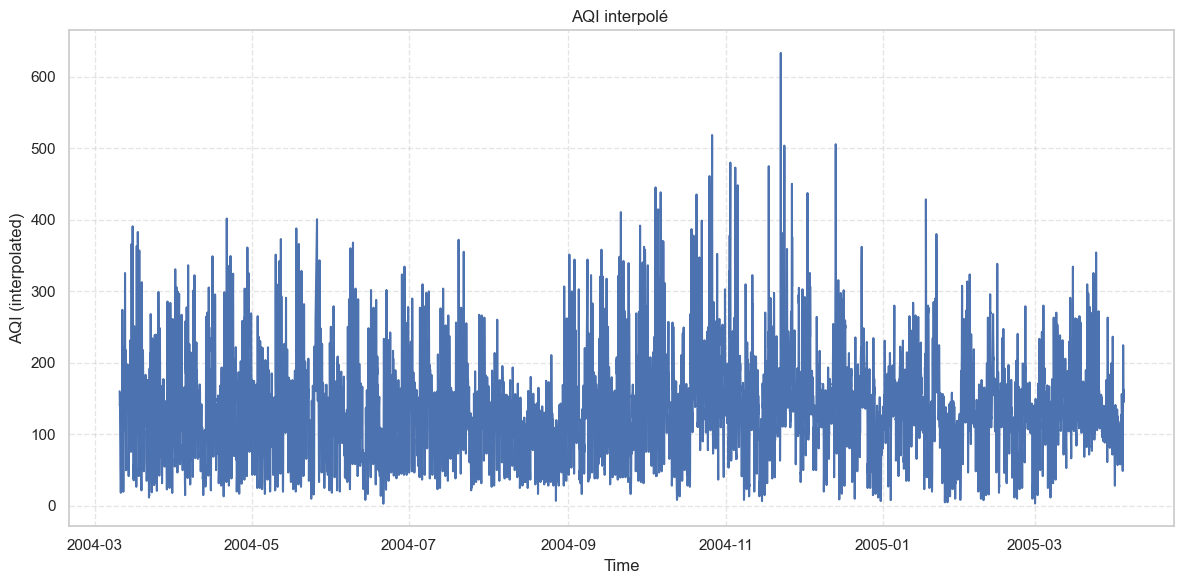

In [18]:
merged_df = merged_df.reset_index(drop=True)
merged_df['datetime'] = pd.to_datetime(
    merged_df['Date'] + ' ' + merged_df['Time'],
    format='%d/%m/%Y %H.%M.%S',
    errors='coerce'
)
merged_df = merged_df.sort_values('datetime').set_index('datetime')
merged_df['AQI_interp'] = merged_df['AQI'].interpolate(
    method='time',
    limit=7,
    limit_direction='both'
)
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index, merged_df['AQI_interp'], linewidth=1.5)
plt.xlabel("Time")
plt.ylabel("AQI (interpolated)")
plt.title("AQI interpolé ")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [19]:
print (merged_df['AQI'].isna().any())

True


In [20]:
merged_df[merged_df['AQI'].isna()]


,Date,Time,CO(GT),NMHC(GT),C6H6(GT),NOx(GT),NO2(GT),T,RH,AH,...,terrestrial_radiation (W/m²),pressure_msl (hPa),soil_temperature_0_to_7cm (°C),I_CO,I_NMHC,I_C6H6,I_NOx,I_NO2,AQI,AQI_interp
datetime,,,,,,,,,,,,,,,,,,,,,
2004-05-25 19:00:00,25/05/2004,19.00.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,43.5,1016.8,17.2,NaN,NaN,NaN,NaN,NaN,NaN,259.608000
2004-05-25 20:00:00,25/05/2004,20.00.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1017.3,16.2,NaN,NaN,NaN,NaN,NaN,NaN,269.706000
2004-05-25 21:00:00,25/05/2004,21.00.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1017.7,15.1,NaN,NaN,NaN,NaN,NaN,NaN,279.804000
2004-05-25 22:00:00,25/05/2004,22.00.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1017.4,14.2,NaN,NaN,NaN,NaN,NaN,NaN,289.902000
2004-05-25 23:00:00,25/05/2004,23.00.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1017.6,13.6,NaN,NaN,NaN,NaN,NaN,NaN,300.000000
2004-05-26 00:00:00,26/05/2004,00.00.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1017.6,13.1,NaN,NaN,NaN,NaN,NaN,NaN,310.098000
2004-05-26 01:00:00,26/05/2004,01.00.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1017.6,12.7,NaN,NaN,NaN,NaN,NaN,NaN,320.196000
2004-05-26 02:00:00,26/05/2004,02.00.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1017.3,12.3,NaN,NaN,NaN,NaN,NaN,NaN,330.294000
2004-05-26 03:00:00,26/05/2004,03.00.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1017.3,12.0,NaN,NaN,NaN,NaN,NaN,NaN,340.392000


In [21]:
merged_df[merged_df['AQI_interp'].isna()]

,Date,Time,CO(GT),NMHC(GT),C6H6(GT),NOx(GT),NO2(GT),T,RH,AH,...,terrestrial_radiation (W/m²),pressure_msl (hPa),soil_temperature_0_to_7cm (°C),I_CO,I_NMHC,I_C6H6,I_NOx,I_NO2,AQI,AQI_interp
datetime,,,,,,,,,,,,,,,,,,,,,


在经过插值处理之后原本不连续的时间序列变得连续，方便后续利用SARIMA模型对时间序列进行建模处理。

Après le traitement d'interpolation, la série temporelle non-continue devient continue, ce qui facilite la modélisation ultérieure de la série temporelle à l'aide du modèle SARIMA.

In [22]:
merged_df=merged_df.drop(columns=['AQI'])

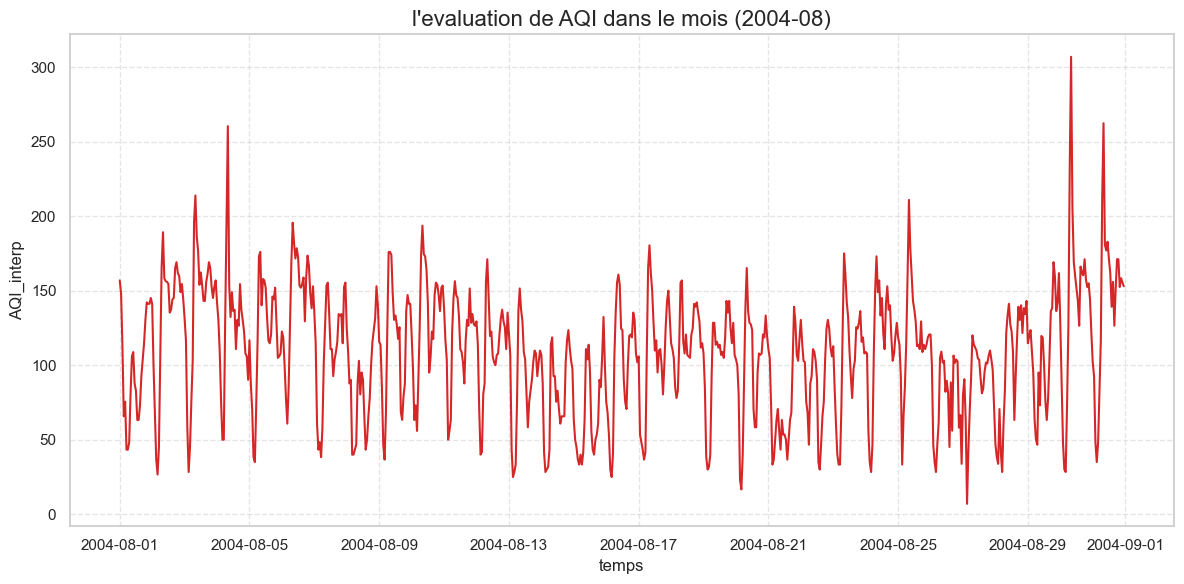

In [23]:
# month extract
month = '2004-08'
merged_df['datetime'] = pd.to_datetime(
    merged_df['Date'] + ' ' + merged_df['Time'],
    format='%d/%m/%Y %H.%M.%S',
    errors='coerce'
)
df_month = merged_df[merged_df['datetime'].dt.strftime('%Y-%m') == month]

plt.figure(figsize=(12, 6))
plt.plot(df_month['datetime'], df_month['AQI_interp'], color='tab:red', linewidth=1.5)
plt.title(f"l'evaluation de AQI dans le mois ({month})", fontsize=16)
plt.xlabel("temps", fontsize=12)
plt.ylabel("AQI_interp", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 清洗 Netoyage <a id="part1sec3"></a>

最后，我们将纳入与特定节假日和每周工作日相关的解释变量。

Enfin, nous intégrerons des variables relatives aux jours fériés spécifiques et aux jours ouvrables hebdomadaires.

In [24]:
italy_holidays = holidays.IT()

merged_df['weekday'] = merged_df['datetime'].dt.weekday + 1  # Monday=1 ... Sunday=7

merged_df['is_holiday'] = merged_df['datetime'].dt.date.isin(italy_holidays).astype(int)




In [25]:
cols1 = ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'I_CO', 
         'I_NMHC', 'I_C6H6', 'I_NOx', 'I_NO2']
merged_df=merged_df.drop(columns=cols1)

In [26]:
merged_df.columns


Index(['Date', 'Time', 'T', 'RH', 'AH', 'precipitation (mm)',
       'cloud_cover (%)', 'wind_speed_10m (km/h)',
       'terrestrial_radiation (W/m²)', 'pressure_msl (hPa)',
       'soil_temperature_0_to_7cm (°C)', 'AQI_interp', 'datetime', 'weekday',
       'is_holiday'],
      dtype='object')

## 数据分析 Analyse des données <a id="part1sec4"></a>

In [27]:
df_plot=merged_df.drop(columns=['Date','Time']).copy()
time_cols = ['datetime', 'weekday', 'is_holiday']
num_cols = [col for col in df_plot.columns if col not in time_cols]
print (num_cols)

['T', 'RH', 'AH', 'precipitation (mm)', 'cloud_cover (%)', 'wind_speed_10m (km/h)', 'terrestrial_radiation (W/m²)', 'pressure_msl (hPa)', 'soil_temperature_0_to_7cm (°C)', 'AQI_interp']


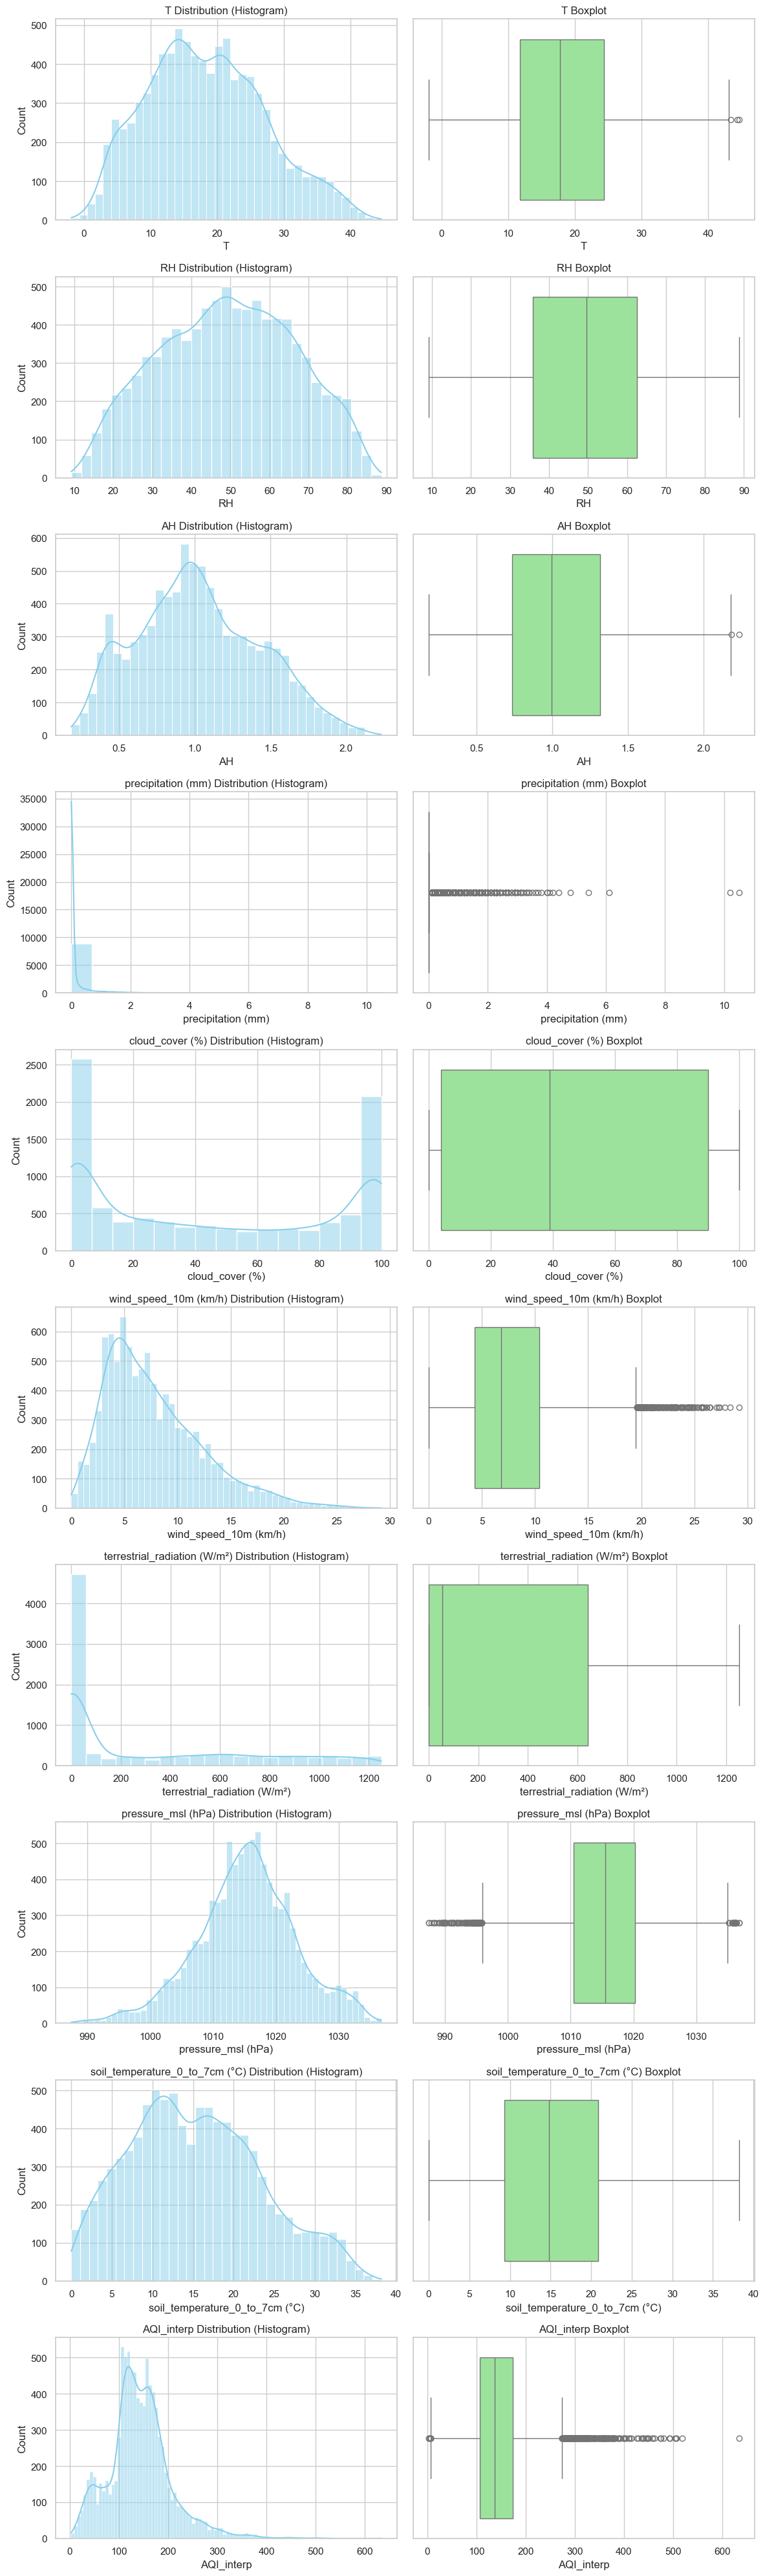

In [28]:
fig, axes = plt.subplots(len(num_cols), 2, figsize=(12, 4*len(num_cols)))
for i, col in enumerate(num_cols):
    sns.histplot(df_plot[col], ax=axes[i, 0], kde=True, color='skyblue')
    axes[i, 0].set_title(f'{col} Distribution (Histogram)')
    
    sns.boxplot(x=df_plot[col], ax=axes[i, 1], color='lightgreen')
    axes[i, 1].set_title(f'{col} Boxplot')

plt.tight_layout()
plt.show()


我们采用普通最小二乘法（OLS）进行线性回归，将空气质量指数（AQI）作为因变量，气象变量作为解释变量。结果显示，决定系数相对较低（R² = 0.074），这表明在严格的线性和即时框架下，气象因素仅能解释 AQI 变异性中的一小部分。尽管如此，整体 F 检验具有高度显著性（p = 4.04×10⁻¹⁴³），这从统计学角度证实了气象变量对 AQI 的线性影响确实存在。杜宾 - 沃森统计量为 0.349，表明残差存在强烈的正自相关，说明模型误差具有显著的时间依赖性；这意味着污染的变化具有很大的惯性，而静态线性模型无法捕捉到这一点，这也是其解释能力较弱的主要原因之一。此外，较高的条件数（1.63×10⁵）表明某些气象变量之间存在强烈的多重共线性，这可能导致个体系数不稳定，并降低显著性检验的可靠性，即便模型的整体拟合仍然有效。在完全共线性的情况下，矩阵$X^TX$将变得不可逆，从而无法计算 OLS 估计量。因此，尽管该模型揭示了气象与空气质量之间存在统计上显著的线性关系，但它无法充分反映 AQI 的动态变化，因为 AQI 的变化还强烈依赖于时间结构，且可能受到非线性效应的影响

Nous avons appliqué une régression linéaire par moindres carrés ordinaires (OLS) en prenant l’indice de qualité de l’air (AQI) comme variable dépendante et les variables météorologiques comme variables explicatives. Les résultats montrent un coefficient de détermination relativement faible (R² = 0,074), indiquant que, dans un cadre strictement linéaire et instantané, la météo n’explique qu’une part limitée de la variabilité de l’AQI. Néanmoins, le test global de Fisher est hautement significatif (p = 4,04×10⁻¹⁴³), ce qui confirme que l’influence linéaire des variables météorologiques sur l’AQI existe bien d’un point de vue statistique. La statistique de Durbin–Watson, égale à 0,349, révèle une forte autocorrélation positive des résidus, montrant que les erreurs du modèle présentent une dépendance temporelle marquée ; cela suggère que l’évolution de la pollution possède une inertie importante que le modèle linéaire statique ne capture pas, ce qui constitue l’une des principales raisons de sa faible capacité explicative. Par ailleurs, le condition number élevé (1,63×10⁵) indique une forte multicolinéarité entre certaines variables météorologiques, ce qui peut rendre les coefficients individuels instables et réduire la fiabilité des tests de significativité, même si l’ajustement global du modèle reste valide. En cas de colinéarité parfaite, la matrice $X^TX$ deviendrait non inversible, rendant impossible le calcul de l’estimateur OLS. Ainsi, si ce modèle met en évidence une relation linéaire statistiquement significative entre météo et qualité de l’air, il ne parvient pas à représenter pleinement la dynamique de l’AQI, qui dépend aussi fortement de structures temporelles et probablement d’effets non linéaires.

In [29]:
import statsmodels.api as sm
cols_weather=['T', 'RH', 'AH', 'wind_speed_10m (km/h)', 'precipitation (mm)',
       'cloud_cover (%)', 'pressure_msl (hPa)',
       'terrestrial_radiation (W/m²)']

X = merged_df[cols_weather]
X = sm.add_constant(X)
y = merged_df['AQI_interp']

model = sm.OLS(y, X, missing='drop').fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             AQI_interp   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     89.24
Date:                Thu, 12 Feb 2026   Prob (F-statistic):          4.04e-143
Time:                        14:47:52   Log-Likelihood:                -49698.
No. Observations:                8991   AIC:                         9.941e+04
Df Residuals:                    8982   BIC:                         9.948e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

我们对空气质量指数（AQI）的时间序列应用了 STL 分解法。

$
AQI_t = T_t + S_t + \varepsilon_t,
\qquad t = 1,\dots,n.
$

这种方法能将该序列分解为三个部分：趋势项（Trend）、季节项（Seasonal）和残差项（Residual）。在第一行中，我们可以看到原始序列：AQI 值变化很大，有许多峰值，且整体水平会随时期不同而变化。这表明污染并非随机的，而是在时间上遵循一定的结构。
第二行对应的是趋势项，也就是去除日周期后污染的缓慢变化情况。我们观察到，2004 年春季和夏季（大约4月至9月）的平均污染水平较低，不过在5月底左右有一个峰值。相反，秋季和冬季（9月至次年2月）的平均水平较高。这与实际情况相符：冬季天气更寒冷，空气扩散能力较差，而且由于供暖，排放量增加，因此污染更容易积聚。
第三行显示的是日季节性，即每天重复出现的变化。可以看到高频的规律性波动。这些波动与太阳辐射的变化、大气边界层的高度以及一天中的人类活动有关。这部分的平均值接近零，因为 STL 方法要求一个周期内的平均值为零。我们还注意到，冬季日周期的振幅更大，这意味着当扩散条件较差时，昼夜差异对污染的影响更大。
最后一行代表残差项，也就是去除趋势项和日季节项后剩下的部分。这部分更不规则，更像是噪声。我们有时会看到极端值，这可能对应于突发的污染事件或特殊的气象情况。残差的平均值也接近零，对于随机成分来说，这是正常的。我们观察到冬季的波动更大，这表明在这一时期，污染系统更不稳定。但平均水平的主要变化仍主要由趋势项解释，而非新的季节性因素。


Nous avons appliqué une décomposition STL à la série temporelle de l’indice de pollution AQI

$
AQI_t = T_t + S_t + \varepsilon_t,
\qquad t = 1,\dots,n.
$


Cette méthode permet de séparer la série en trois parties : la tendance (Trend), la saisonnalité (Seasonal) et le résidu (Residual). Sur la première ligne, on voit la série originale : les valeurs d’AQI varient beaucoup, avec de nombreux pics, et le niveau général change selon la période. Cela montre que la pollution n’est pas aléatoire, mais qu’elle suit une certaine structure dans le temps.

La deuxième ligne correspond à la tendance, c’est-à-dire l’évolution lente de la pollution après avoir retiré le cycle journalier. On observe que le niveau moyen de pollution est plus faible au printemps et en été 2004 (environ d’avril à septembre), sauf un pic vers la fin mai. En revanche, en automne et en hiver (de septembre à février), le niveau moyen est plus élevé. Cela correspond bien à la réalité physique : en hiver, il fait plus froid, la dispersion de l’air est moins bonne, et les émissions augmentent à cause du chauffage, donc la pollution s’accumule plus facilement.

La troisième ligne montre la saisonnalité journalière, c’est-à-dire les variations qui se répètent chaque jour. On observe des oscillations régulières à haute fréquence. Elles sont liées aux changements de rayonnement solaire, à la hauteur de la couche limite atmosphérique, et aux activités humaines au cours de la journée. La moyenne de cette composante est proche de zéro, car la méthode STL impose que la moyenne sur un cycle soit nulle. On remarque aussi que l’amplitude du cycle journalier est plus grande en hiver, ce qui veut dire que la différence entre le jour et la nuit influence davantage la pollution quand les conditions de dispersion sont mauvaises.

La dernière ligne représente le résidu, c’est-à-dire ce qu’il reste après avoir retiré la tendance et la saisonnalité journalière. Cette partie est plus irrégulière et ressemble davantage à du bruit. On voit parfois des valeurs extrêmes, qui peuvent correspondre à des épisodes de pollution soudains ou à des situations météo particulières. La moyenne du résidu est aussi proche de zéro, ce qui est normal pour une composante aléatoire. On observe que les fluctuations sont plus fortes en hiver, ce qui montre que le système de pollution est plus instable pendant cette période. Mais les variations principales du niveau moyen restent surtout expliquées par la tendance, et non par une nouvelle saisonnalité.

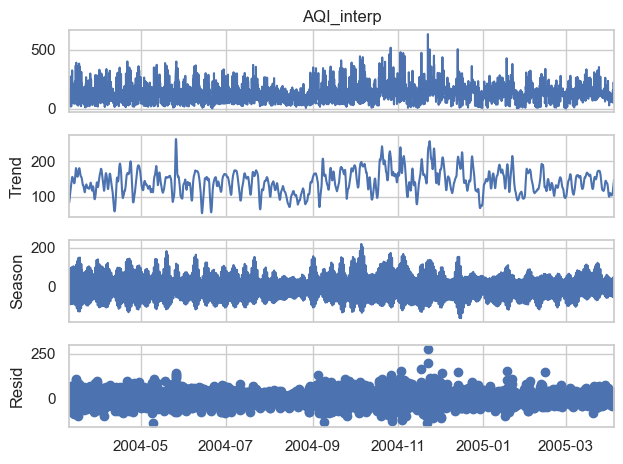

In [30]:
from statsmodels.tsa.seasonal import STL
stl = STL(merged_df.set_index('datetime')['AQI_interp'], period=24)
res = stl.fit()
fig=res.plot()

## 训练集 - 测试集拆分 Train-Test Split <a id="part1sec5"></a>

在开始正式训练之前，必须将数据集划分为训练集和测试集。我们按 6/4 的比例进行划分，同时为每个数据点添加其前24小时和前7天的监测数据作为参考。由于历史值很容易获取，这一过程完全合理，并且能显著改善模型的优化效果。

Avant de commencer la formation formelle, l'ensemble de données doit être divisé en ensembles de formation et de test. Nous effectuons une division en 4/6, en ajoutant simultanément à chaque point de données ses données de surveillance des 24 heures et des 7 jours précédents à titre de référence. Les valeurs historiques étant facilement disponibles, cette procédure est entièrement conforme et améliore considérablement l'optimisation du modèle.

In [31]:
merged_df['AQI_lag_24h'] = merged_df['AQI_interp'].shift(24)     # un jour avant
merged_df['AQI_lag_168h'] = merged_df['AQI_interp'].shift(168)  # une semaine avante

merged_df = merged_df.dropna()#eliminer AQI_interp nan
df_clean = merged_df.copy()

In [32]:
df_clean

,Date,Time,T,RH,AH,precipitation (mm),cloud_cover (%),wind_speed_10m (km/h),terrestrial_radiation (W/m²),pressure_msl (hPa),soil_temperature_0_to_7cm (°C),AQI_interp,datetime,weekday,is_holiday,AQI_lag_24h,AQI_lag_168h
datetime,,,,,,,,,,,,,,,,,
2004-03-17 18:00:00,17/03/2004,18.00.00,25.9,16.0,0.5237,0.0,45,5.4,22.3,1030.0,14.1,270.300000,2004-03-17 18:00:00,3,0,189.220000,160.310000
2004-03-17 19:00:00,17/03/2004,19.00.00,23.1,26.5,0.7403,0.0,72,3.8,0.0,1030.4,13.0,383.160000,2004-03-17 19:00:00,3,0,195.590000,144.120000
2004-03-17 20:00:00,17/03/2004,20.00.00,20.5,38.2,0.9133,0.0,73,2.3,0.0,1030.8,12.1,350.490000,2004-03-17 20:00:00,3,0,179.420000,140.200000
2004-03-17 21:00:00,17/03/2004,21.00.00,19.1,42.6,0.9294,0.0,73,0.7,0.0,1031.0,11.7,272.280000,2004-03-17 21:00:00,3,0,249.510000,142.160000
2004-03-17 22:00:00,17/03/2004,22.00.00,17.2,44.1,0.8558,0.0,95,0.8,0.0,1031.2,11.4,175.500000,2004-03-17 22:00:00,3,0,168.150000,115.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,04/04/2005,10.00.00,21.9,29.3,0.7568,0.0,1,1.9,1003.0,1028.7,15.7,169.947868,2005-04-04 10:00:00,1,0,113.433374,122.852597
2005-04-04 11:00:00,04/04/2005,11.00.00,24.3,23.7,0.7119,0.0,8,3.1,1085.7,1028.0,16.9,157.860000,2005-04-04 11:00:00,1,0,114.375297,123.606135
2005-04-04 12:00:00,04/04/2005,12.00.00,26.9,18.3,0.6406,0.0,47,4.2,1100.6,1027.4,17.6,162.760000,2005-04-04 12:00:00,1,0,115.505603,116.635910


In [33]:
#séparation des ensembles
indices = merged_df.shape[0]
train_idx, test_idx = np.array([i for i in range(0,int(indices*0.6)+1)] ),np.array([i for i in range(int(indices*0.6)+1,indices)] )
df_clean = df_clean.drop(columns=['Date','Time'], errors='ignore')

X = df_clean.drop(columns=['AQI_interp'], errors='ignore')
X['datetime'] = X['datetime'].view('int64')// 10**9

y = df_clean["AQI_interp"]


X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]

#normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Y_train, Y_test= y.iloc[train_idx],y.iloc[test_idx]

# 初步模型 Premières Modèles <a id="part2"></a>

In [34]:
df_cleaned = df_clean.copy() # recopie pour faire cette partie uniquement

## 季节性自回归积分滑动平均模型 SARIMA  
<a id="part2sec1"></a>

### 自相关函数（ACF）绘图的目标
在为空气质量指数（AQI）序列构建季节性自回归整合移动平均（SARIMA）模型之前，必须分析信号的时间依赖结构：
验证连续观测值之间是否存在强自相关性；
揭示可能存在的季节性；
为模型参数的选择提供指示：
非季节性部分的
(p,d,q)
和季节性部分的
(P,D,Q,m)
。
为此，我们计算并绘制 AQI 连续序列（每小时采样一次）的自相关函数（ACF），滞后时间长达 168（7天）。
因此，该图表可作为探索性工具，用于指导 SARIMA 模型的设定。
### Objectif du tracé de l’ACF

Avant de construire un modèle SARIMA pour la série AQI, il est indispensable d’analyser la **structure de dépendance temporelle** du signal :

- vérifier s’il existe une **autocorrélation forte** entre les observations successives ;
- mettre en évidence une éventuelle **saisonnalité** ;
- obtenir des indications pour le choix des paramètres du modèle :  
  \((p,d,q)\) pour la partie non saisonnière et \((P,D,Q,m)\) pour la partie saisonnière.

Pour cela, on calcule et on trace la **fonction d’autocorrélation (ACF)** de la séquence continue d’AQI (échantillonnée toutes les heures), en allant jusqu’à 168 retards (7 jours).  
Ce graphe sert donc d’outil exploratoire pour guider la spécification du modèle SARIMA .


<Figure size 1200x400 with 0 Axes>

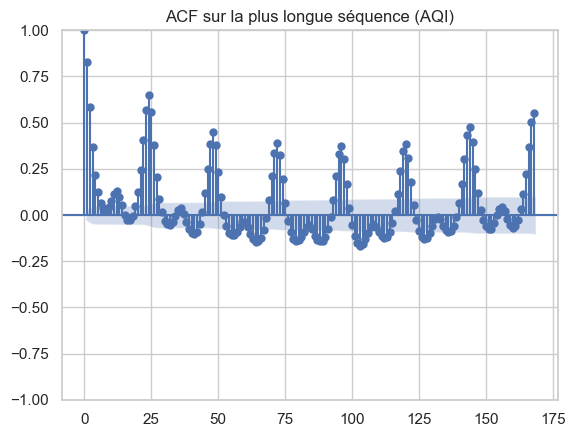

In [35]:
plt.figure(figsize=(12,4))
plot_acf(Y_train, lags=7*24)
plt.title("ACF sur la plus longue séquence (AQI)")
plt.show()

### 自相关函数（ACF）图表分析
通过对自相关函数图表的解读，我们可以观察到几个重要要点：
1. **在 24 的倍数滞后期（24、48、72……168）出现明显峰值**
- 滞后期为 24、48、72 等时，自相关性显著为正。
- 这意味着在时刻 \(t\)
的空气质量指数（AQI）值与 24 小时前、48 小时前等观测到的值存在强相关性。
- 这是**24 小时周期季节性**（日循环）的典型特征。
2. **小滞后期（1 至约 10 小时）存在不可忽视的自相关性**
- 随着滞后期的增加，自相关函数逐渐下降。
- 因此，该序列具有**短期依赖性**：连续的值并非相互独立。
- 这表明模型的非季节性部分存在自回归（AR）和 / 或移动平均（MA）成分（参数
p
和
q
）。
3. **自相关函数的整体表现**
- 除了 24 的倍数之外，大多数自相关系数接近零或在零附近波动，这与经过预处理后序列具有合理的平稳性相符。
- 在 24 的倍数处反复出现的峰值表明，在一周的时间范围内，季节性结构是稳定的。


###  Analyse du graphique ACF

À la lecture du graphique ACF, on observe plusieurs points importants :

1. **Pics marqués aux retards multiples de 24 (24, 48, 72, …, 168)**  
   - L’autocorrélation est nettement positive pour les retards 24, 48, 72, etc.  
   - Cela signifie que la valeur d’AQI à l’instant \(t\) est fortement corrélée à la valeur observée 24 heures plus tôt, 48 heures plus tôt, etc.  
   - C’est la signature classique d’une **saisonnalité de période 24 heures** (cycle journalier).

2. **Autocorrélation non négligeable pour les petits retards (1 à ~10 heures)**  
   - L’ACF décroît progressivement à mesure que le retard augmente.  
   - La série présente donc une **dépendance de court terme** : les valeurs successives ne sont pas indépendantes.  
   - Cela suggère la présence de composantes AR et/ou MA dans la partie non saisonnière du modèle (paramètres \(p\) et \(q\)).

3. **Comportement global de l’ACF**  
   - En dehors des multiples de 24, la plupart des coefficients d’autocorrélation restent proches de zéro ou oscillent autour de zéro, ce qui est compatible avec une série raisonnablement stationnaire après traitement préalable.  
   - Les pics répétés aux multiples de 24 montrent que la structure saisonnière est stable sur l’horizon d’une semaine.


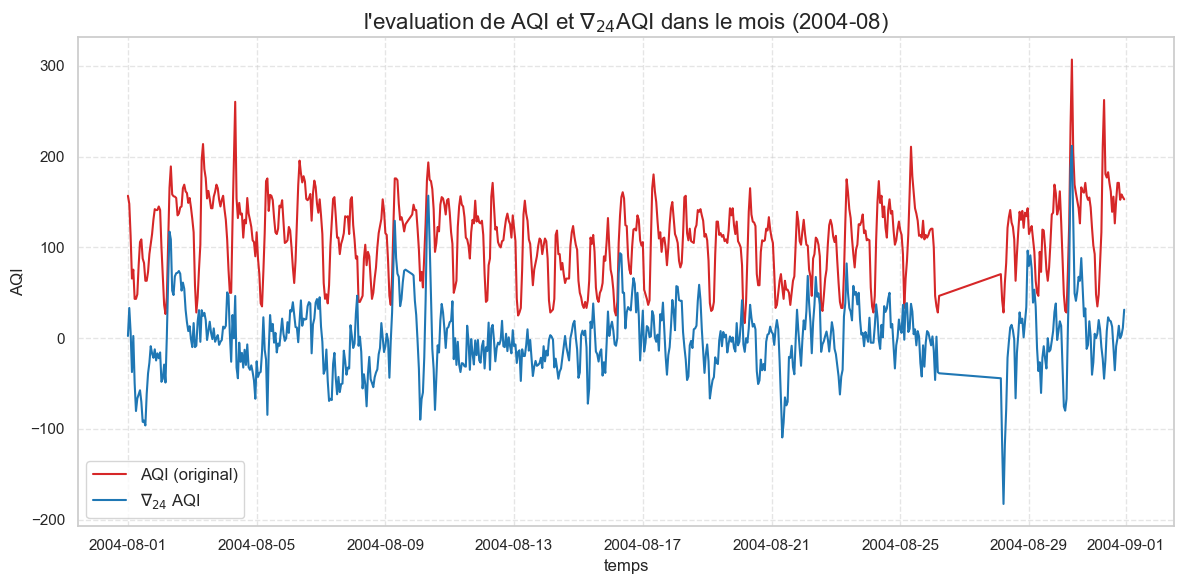

In [36]:
df_cleaned['AQI_diff24'] = df_cleaned['AQI_interp'].diff(24)
month = '2004-08'
df_month = df_cleaned[df_cleaned['datetime'].dt.strftime('%Y-%m') == month]

plt.figure(figsize=(12, 6))
plt.plot(df_month['datetime'], df_month['AQI_interp'], 
         color='tab:red', linewidth=1.5, label='AQI (original)')
plt.plot(df_month['datetime'], df_month['AQI_diff24'], 
         color='tab:blue', linewidth=1.5, label=r'$\nabla_{24}$ AQI')
plt.title(f"l'evaluation de AQI et $\\nabla_{{24}}$AQI dans le mois ({month})",
          fontsize=16)
plt.xlabel("temps", fontsize=12)
plt.ylabel("AQI", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### 季节性差分阶数的选择

通过对比季节性差分**之前**和**之后**的序列，我们观察到原始 AQI 序列呈现出明显的 24 小时季节性模式。
经过 1 阶季节性差分（周期
m=24
）后：
- 日周期性几乎完全消失；
- 序列的均值变得更加**稳定**；
- 信号中不再存在明显的重复结构。
  
因此，本研究选择的季节性差分阶数为：

$$D = 1 \quad \text{(季节性周期} m = 24\text{ 小时).}$$。

### Choix de l’ordre de différenciation saisonnière

D’après la comparaison des séries **avant** et **après** le différenciement saisonnier,  
on observe que la série AQI originale présente un **schéma saisonnier clair de 24 heures**.

Après une différenciation saisonnière d’ordre $1$ (période $m = 24$) :

- la périodicité journalière disparaît quasiment complètement ;
- la moyenne de la série devient plus **stable** ;
- aucune structure répétitive marquée ne subsiste dans le signal.

Ainsi, cette étude retient un **ordre de différenciation saisonnière** :

$$D = 1 \quad \text{(avec une période saisonnière } m = 24\text{ heures).}$$

In [37]:
s_diff = df_cleaned['AQI_diff24']
N = len(s_diff)
conf = 1.96 / np.sqrt(N)  
acf_vals = acf(s_diff, nlags=24, fft=False)
pacf_vals = pacf(s_diff, nlags=24, method='ywm')
Q = 1 if abs(acf_vals[24]) > conf else 0
P = 1 if abs(pacf_vals[24]) > conf else 0
print("Sélection préliminaire des termes saisonniers basée sur l'ensemble de la séquence de différences :")
print(f"P = {P}, Q = {Q} (Période m=24, différenciation saisonnière D=1)")

Sélection préliminaire des termes saisonniers basée sur l'ensemble de la séquence de différences :
P = 0, Q = 0 (Période m=24, différenciation saisonnière D=1)


### 基于差分序列整体的季节项参数初步选择：
**P = 0，Q = 0**（周期 m=24，季节性差分 D=1）

In [38]:
best_aic = np.inf
best_order = None
best_res = None
for p in range(0, 3):         # 0,1,2
    for q in range(0, 3):     # 0,1,2
        if p == 0 and q == 0:    
            continue
        try:
            res = ARIMA(s_diff, order=(p, 0, q), trend='n').fit()
            if res.aic < best_aic:
                best_aic = res.aic
                best_order = (p, 0, q)   
                best_res = res
        except Exception:
            pass

print("Ordre optimal d'ARMA pour la série différentielle :", best_order, "  AIC =", best_aic)

/opt/anaconda3/envs/tf-mlp/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/tf-mlp/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/tf-mlp/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/tf-mlp/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Ordre optimal d'ARMA pour la série différentielle : (2, 0, 2)   AIC = 87499.32212979184


### 差分序列的最佳 ARMA 阶数：(2, 0, 2)   AIC = 87499.32212979184

### SARIMA 建模的含义：AR 与 MA 系数的选择

基于**季节差分**后的序列  
$
s_t = \nabla_{24} \, AQI_t = AQI_t - AQI_{t-24},
$

我们首先通过 ACF 与 PACF 在 **24 阶滞后（lag=24）** 处考察**季节性结构**。  
在 lag=24 处，自相关与偏自相关均落在置信区间

$$
\pm \frac{1{,}96}{\sqrt{N}},
$$

之内，说明它们**与 0 并无显著差异**。  
因此，季节性 AR 与 MA 项可设为 0：
$$
P = 0,\quad Q = 0,\quad m = 24,\quad D = 1.
$$

对于**非季节部分**，我们在差分序列 \(s_t\) 上拟合了多个 \(ARMA(p,q)\) 模型，其中
$$
p,q \in \{0,1,2\},
$$

并选择 AIC（赤池信息准则）最小的模型。  
最终得到的最优模型为
$$
ARMA(2,2),
$$
即包含**两个自回归（AR）系数**与**两个滑动平均（MA）系数**，且不再做额外差分（\(d=0\)），并且不包含趋势项（`trend='n'`）。

综上，AQI 序列在进行 **24 小时、1 阶季节差分**后，其动态特征可以用如下 SARIMA 模型刻画：
$$
SARIMA(2,0,2)\times(0,1,0,24),
$$
其中：

- $p = 2$ et $q = 2$  用于捕捉**短期依赖**（非季节的 AR/MA 结构）
- $D = 1$、$m = 24$ 表示进行了**24 小时周期**的**1 阶季节差分**
- $P = 0$、$Q = 0$ 表示**季节性 AR/MA 项不显著**，因此不纳入模型

### Conséquences pour la modélisation SARIMA : choix des coefficients AR et MA

À partir de la série différenciée saisonnièrement  

$s_t = \nabla_{24} \, AQI_t = AQI_t - AQI_{t-24}$,

nous avons d’abord étudié la structure **saisonnière** via l’ACF et la PACF au retard 24.  
Les valeurs d’autocorrélation et d’autocorrélation partielle au lag 24 se situent à l’intérieur de l’intervalle de confiance
$$
\pm \frac{1{,}96}{\sqrt{N}},
$$
ce qui signifie qu’elles **ne sont pas significativement différentes de zéro**.  
En conséquence, les termes saisonniers AR et MA sont fixés à zéro :  
$$
P = 0,\quad Q = 0,\quad m = 24,\quad D = 1.
$$

Pour la partie **non saisonnière**, nous avons ajusté plusieurs modèles $ARMA(p, q)$ sur la série différenciée $s_t$, avec  
$$
p,q \in \{0,1,2\},
$$
et sélectionné le modèle minimisant le critère AIC.  
Le meilleur modèle obtenu est
$$
ARMA(2,2),
$$
c’est-à-dire **deux coefficients autorégressifs (AR)** et **deux coefficients de moyenne mobile (MA)**, sans différenciation supplémentaire ($d = 0$) et sans terme de tendance (`trend='n'`).  

En résumé, la dynamique de la série AQI, après différenciation saisonnière d’ordre 1 à 24 heures, est bien décrite par un modèle SARIMA de la forme :
$$
SARIMA(2,0,2)\times(0,1,0,24),
$$
où :

- $p = 2$ et $q = 2$ capturent la dépendance de **court terme**



In [39]:
# SARIMA(2,1,2)(0,1,0)_24
y_train=Y_train.copy()
y_test=Y_test.copy()
y_train = y_train.asfreq("H")
y_test  = y_test.asfreq("H")
y_train = y_train.asfreq("H").interpolate(limit_direction="both")
y_test  = y_test.asfreq("H").interpolate(limit_direction="both")
y_train = y_train.squeeze()
y_test  = y_test.squeeze()
y_train.name = "AQI"
y_test.name  = "AQI"
model = SARIMAX(
    y_train,
    order=(2, 1, 2),
    seasonal_order=(0, 1, 0, 24),
    enforce_stationarity=True,
    enforce_invertibility=True
)
res = model.fit(disp=True, method="lbfgs", maxiter=300)
print(res.summary())
### 重要说明：已差分序列与原始序列（实现方式）

##必须区分两种情况：
## 1）如果我们处理的是已经进行过一次差分的序列（在建模前已完成非季节性差分），那么我们在模型中设定 d = 0：
##- SARIMA (2,0,2) × (2,1,2,24)
## 2）在代码中，我们使用原始序列（未差分序列）。因此，非季节性差分由模型完成，这意味着 d = 1：
##- SARIMA(2,1,2) × (2,1,2,24)


#### Note importante : série déjà différenciée vs série brute (implémentation)

##Il faut distinguer deux cas :
## 1) Si l’on travaille sur une série déjà différenciée une fois (différenciation non saisonnière faite avant la modélisation), alors on fixe d = 0 dans le modèle :
## - SARIMA(2,0,2) × (2,1,2,24)
## 2) Dans le code, on utilise la série brute (non différenciée). La différenciation non saisonnière est donc faite par le modèle, ce qui implique d = 1 :
## - SARIMA(2,1,2) × (2,1,2,24)

                                      SARIMAX Results                                      
Dep. Variable:                                 AQI   No. Observations:                 5442
Model:             SARIMAX(2, 1, 2)x(0, 1, [], 24)   Log Likelihood              -26774.527
Date:                             Thu, 12 Feb 2026   AIC                          53559.054
Time:                                     14:48:01   BIC                          53592.040
Sample:                                 03-17-2004   HQIC                         53570.568
                                      - 10-30-2004                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1703      0.006    -27.541      0.000      -0.182      -0.158
ar.L2          0.7505      

Test RMSE = 33.30
Test MAE  = 21.95


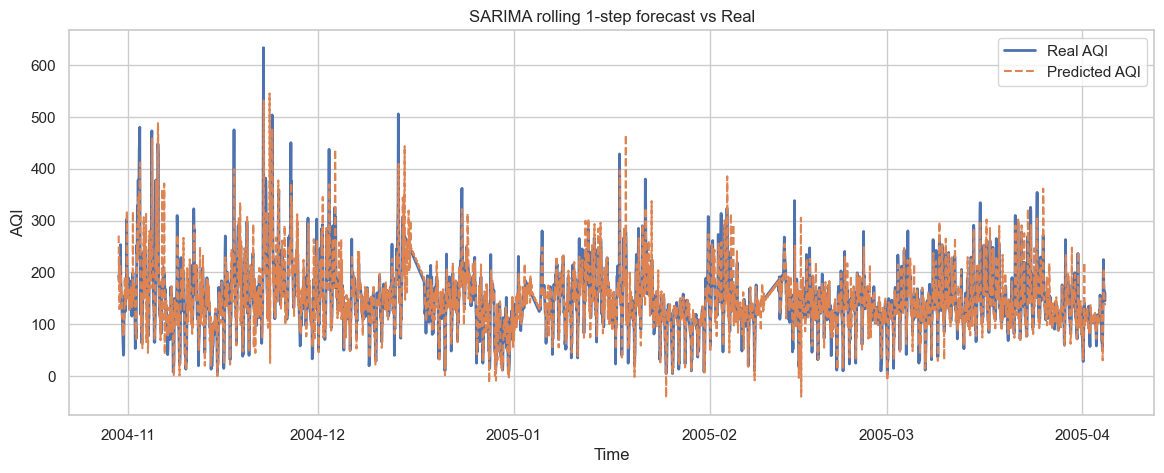

In [40]:
preds = []
res_upd = res
for t, y_true in y_test.items():
    y_pred = res_upd.forecast(steps=1).iloc[0]
    preds.append(y_pred)
    idx = pd.date_range(start=t, periods=1, freq=y_train.index.freq)  # freq=<Hour>
    new_obs = pd.Series([y_true], index=idx, name=y_train.name)
    res_upd = res_upd.extend(new_obs)

Y_pred = pd.Series(preds, index=y_test.index, name="AQI_pred")

rmse = np.sqrt(mean_squared_error(y_test, Y_pred))
mae  = mean_absolute_error(y_test, Y_pred)
print(f"Test RMSE = {rmse:.2f}")
print(f"Test MAE  = {mae:.2f}")

plt.figure(figsize=(14,5))
plt.plot(y_test.index, y_test.values, label="Real AQI", linewidth=2)
plt.plot(Y_pred.index, Y_pred.values, label="Predicted AQI", linestyle="--")
plt.title("SARIMA rolling 1-step forecast vs Real")
plt.xlabel("Time"); plt.ylabel("AQI")
plt.legend(); plt.show()

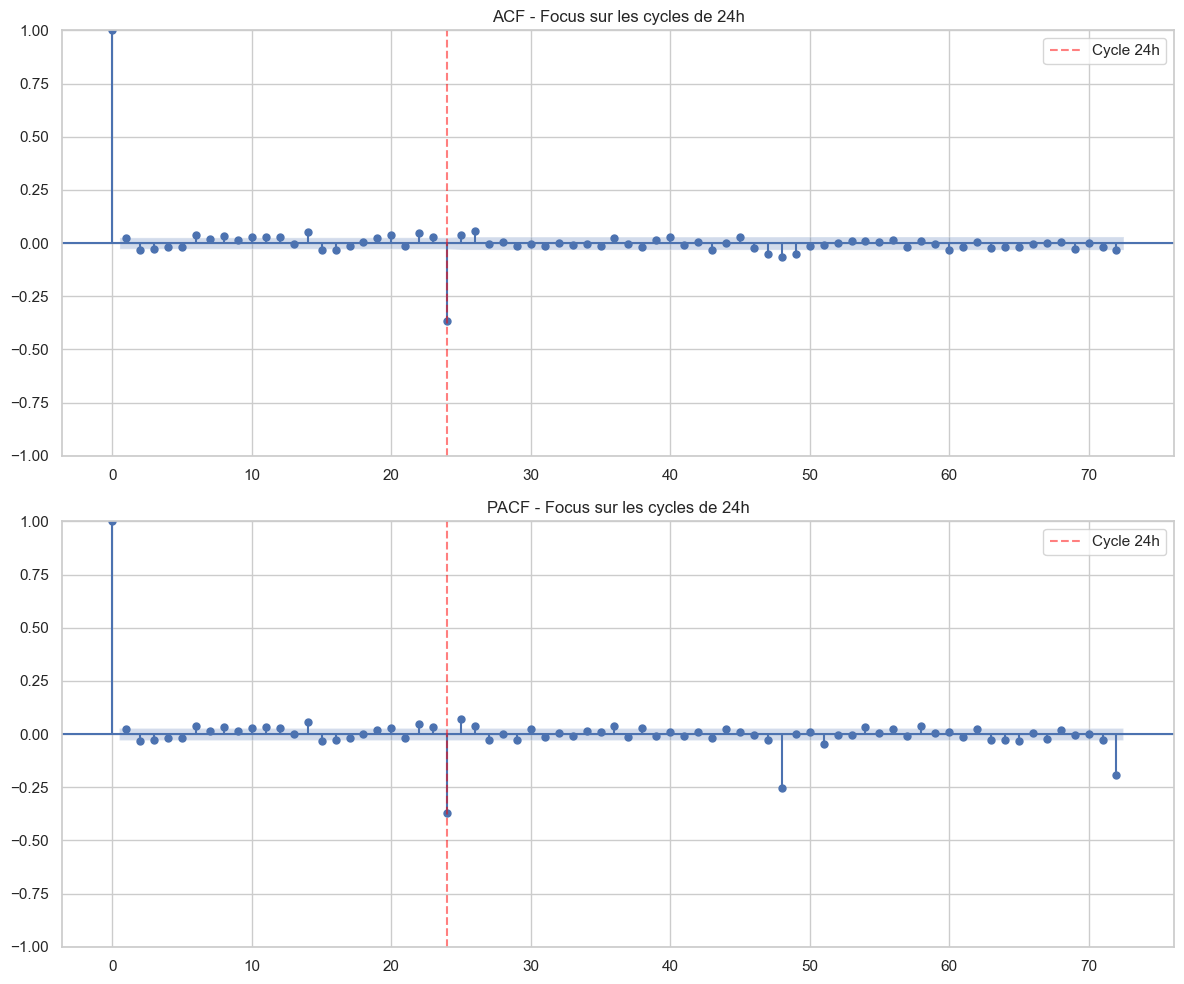

In [41]:
residus= res.resid.dropna()
def plot_resid_diagnostic_custom(residus, period=24):
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))
    
    # ACF
    plot_acf(residus, ax=ax[0], lags=period*3) 
    ax[0].axvline(x=period, color='red', linestyle='--', alpha=0.5, label=f'Cycle {period}h')
    ax[0].set_title(f"ACF - Focus sur les cycles de {period}h")
    ax[0].legend()

    # PACF
    plot_pacf(residus, ax=ax[1], lags=period*3)
    ax[1].axvline(x=period, color='red', linestyle='--', alpha=0.5, label=f'Cycle {period}h')
    ax[1].set_title(f"PACF - Focus sur les cycles de {period}h")
    ax[1].legend()

    plt.tight_layout()
    plt.show()


plot_resid_diagnostic_custom(res.resid.dropna(), period=24)

## 残差检验（ACF / PACF）

模型拟合完成后，需要对**残差（residuals）**进行诊断。  
一个合格的模型应当产生近似**白噪声**的残差：均值接近 0、方差相对稳定，并且最关键的是**不存在显著自相关**。

因此，我们查看残差的 **ACF**（以及 **PACF**），并重点关注 **24 小时的季节滞后（lag=24）**——这对应于小时级数据的日周期。

然而，在 **lag=24** 处，残差的自相关系数**超过了（通常为 95%）置信区间**。  
这表明残差中仍存在**显著的 24 小时依赖性**：换言之，模型**没有完全捕捉**日周期的季节性结构。

**结论：** 当前模型尚未解释 AQI 的全部季节性动态（24 小时周期）。因此可以考虑：
- 在 SARIMA中**加入或调整季节项**（\(P, Q\)），以更好刻画 24 小时周期；
- 引入能够承载该季节性的**外生解释变量**（SARIMAX），例如气象因素、日内/工作日指示变量等。

## Vérification des résidus (ACF / PACF)

Après l’ajustement du modèle, j’analyse les **résidus**.  
Un modèle adéquat doit produire des résidus qui se comportent comme un **bruit blanc** : moyenne proche de zéro, variance stable, et surtout **absence d’autocorrélation significative**.

Pour cela, on examine l’**ACF** (et la **PACF**) des résidus, en portant une attention particulière au **retard saisonnier de 24 heures (lag 24)**, correspondant à un cycle journalier sur des données horaires.

Or, à **lag 24**, le coefficient d’autocorrélation **dépasse la bande de confiance** (généralement à 95 %).  
Cela indique qu’il subsiste une **dépendance significative** à horizon 24 h : autrement dit, la structure saisonnière journalière n’est **pas entièrement capturée** par le modèle.

**Conclusion :** le modèle ne parvient pas à expliquer toute la dynamique saisonnière (cycle de 24 h). Il peut donc être pertinent d’envisager :
- l’ajout ou l’ajustement de termes saisonniers (**P, Q**) dans la partie SARIMA/SARIMAX,
- et/ou l’introduction de variables explicatives (SARIMAX) susceptibles de porter cette saisonnalité (météo, indicateurs journaliers, etc.).


## 季节性阶数（P，Q）的研究
于是，我通过在一个简单的网格上进行搜索来测试更大的季节性阶数：
- P = 0，1，2
- Q = 0，1，2
  
我对性能（例如均方根误差（RMSE）和平均绝对误差（MAE））进行了比较。结果表明，当 P = 2 且 Q = 2 时，误差最小。

因此，改进后的季节性模型为：
季节性自回归积分滑动平均模型
- **（SARIMA）(2,0,2) × (2,1,2,24)**

## Recherche d’ordres saisonniers (P, Q)
Je teste alors des ordres saisonniers plus grands en réalisant une recherche sur une grille simple :
- P = 0, 1, 2
- Q = 0, 1, 2

Je compare les performances (par exemple RMSE et MAE). Les résultats montrent que lorsque P = 2 et Q = 2, l’erreur est la plus faible.

Le modèle saisonnier amélioré est donc :
- **SARIMA(2,0,2) × (2,1,2,24)**


In [42]:
y_train=Y_train.copy()
y_test=Y_test.copy()
y_train = y_train.asfreq("H")
y_test  = y_test.asfreq("H")
y_train = y_train.asfreq("H").interpolate(limit_direction="both")
y_test  = y_test.asfreq("H").interpolate(limit_direction="both")
y_train = y_train.squeeze()
y_test  = y_test.squeeze()
y_train.name = "AQI"
y_test.name  = "AQI"

model = SARIMAX(
    y_train,
    order=(2, 1, 2),
    seasonal_order=(2, 1, 2, 24),
    enforce_stationarity=True,
    enforce_invertibility=True
)
res = model.fit(disp=True, method="lbfgs", maxiter=300)

preds = []
res_upd = res

for t, y_true in y_test.items():
    y_pred = res_upd.forecast(steps=1).iloc[0]
    preds.append(y_pred)
    idx = pd.date_range(start=t, periods=1, freq=y_train.index.freq)  # freq=<Hour>
    new_obs = pd.Series([y_true], index=idx, name=y_train.name)
    res_upd = res_upd.extend(new_obs)

Y_pred = pd.Series(preds, index=y_test.index, name="AQI_pred")


In [43]:
rmse = np.sqrt(mean_squared_error(y_test, Y_pred))
mae  = mean_absolute_error(y_test, Y_pred)
print(f"Test RMSE = {rmse:.2f}")
print(f"Test MAE  = {mae:.2f}")

Test RMSE = 26.05
Test MAE  = 17.32


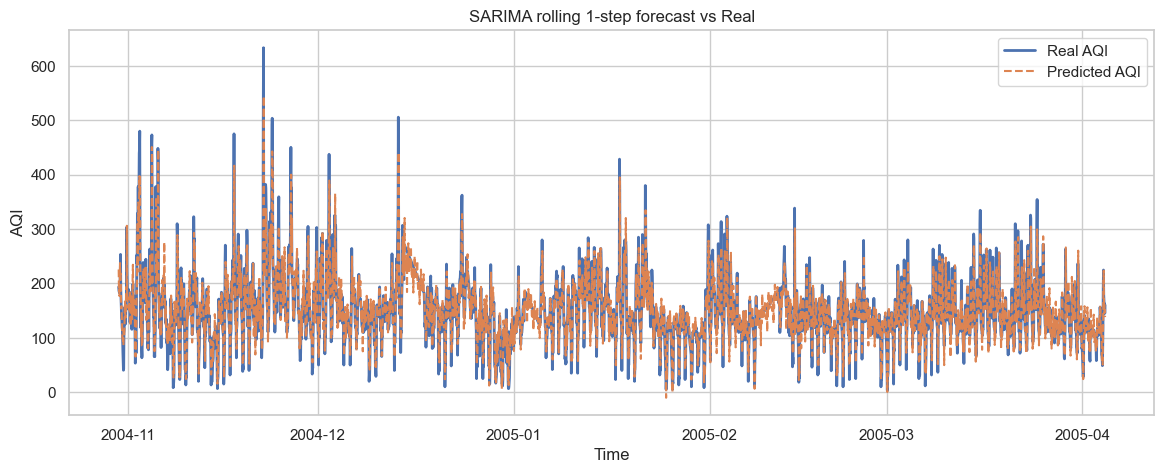

In [44]:
plt.figure(figsize=(14,5))
plt.plot(y_test.index, y_test.values, label="Real AQI", linewidth=2)
plt.plot(Y_pred.index, Y_pred.values, label="Predicted AQI", linestyle="--")
plt.title("SARIMA rolling 1-step forecast vs Real")
plt.xlabel("Time"); plt.ylabel("AQI")
plt.legend(); plt.show()

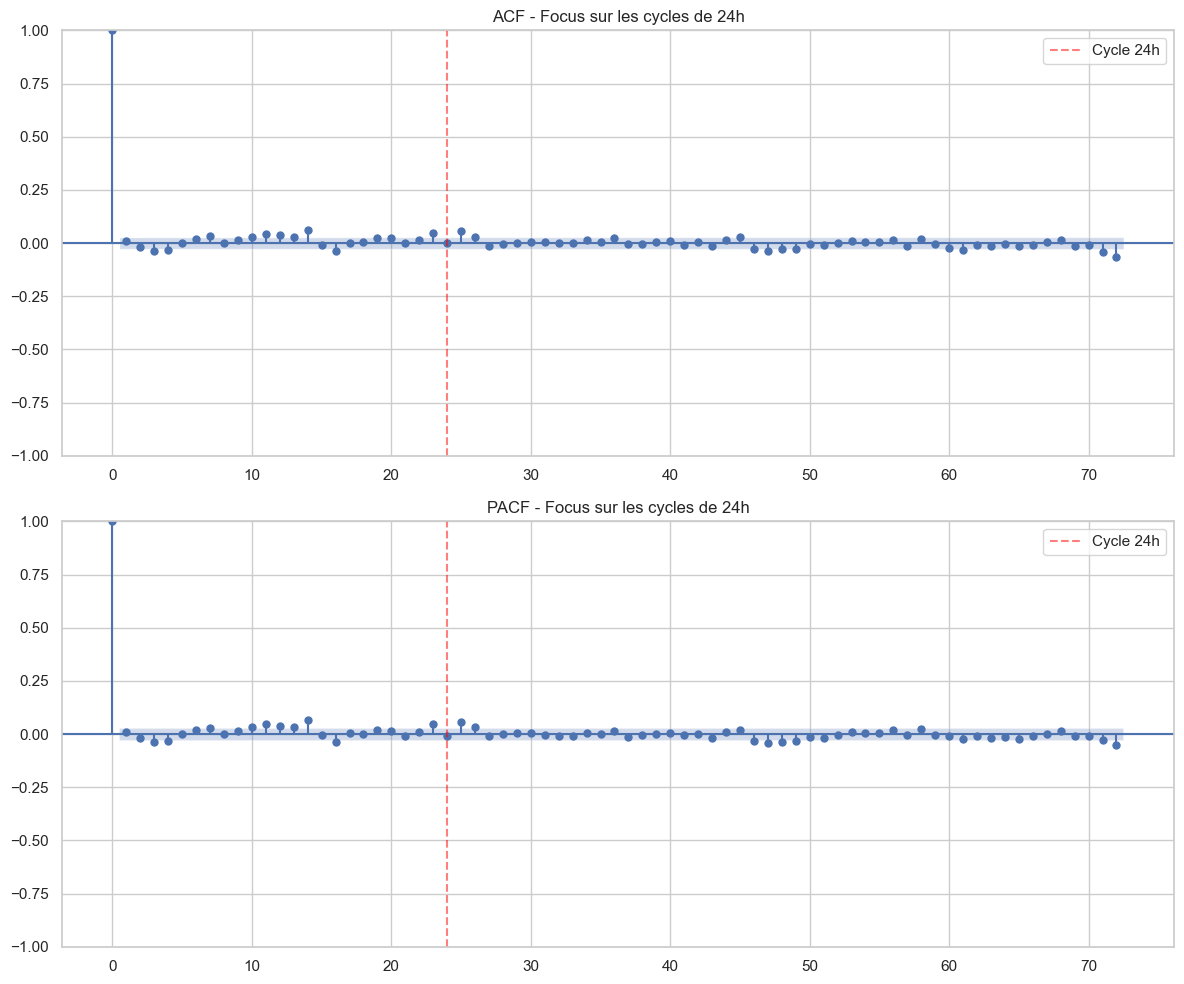

In [45]:
residus= res.resid.dropna()
def plot_resid_diagnostic_custom(residus, period=24):
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))
    
    # ACF
    plot_acf(residus, ax=ax[0], lags=period*3) 
    ax[0].axvline(x=period, color='red', linestyle='--', alpha=0.5, label=f'Cycle {period}h')
    ax[0].set_title(f"ACF - Focus sur les cycles de {period}h")
    ax[0].legend()

    # PACF
    plot_pacf(residus, ax=ax[1], lags=period*3)
    ax[1].axvline(x=period, color='red', linestyle='--', alpha=0.5, label=f'Cycle {period}h')
    ax[1].set_title(f"PACF - Focus sur les cycles de {period}h")
    ax[1].legend()

    plt.tight_layout()
    plt.show()


plot_resid_diagnostic_custom(res.resid.dropna(), period=24)

## 残差的改进

经过这一变化，残差的自相关函数（ACF）得到改善：在滞后 24 处，该点回到了置信区间内。这表明模型能更好地捕捉 24 小时的季节性成分。
## Amélioration des résidus
Après ce changement, l’ACF des résidus s’améliore : au lag 24, le point revient à l’intérieur de la bande de confiance. Cela suggère que la composante saisonnière à 24 heures est mieux capturée par le modèle.


## 加入外生变量的 SARIMAX <a id="part2sec2"></a>

为提升相较“基础”SARIMA 的预测效果，我们在 SARIMAX 模型中引入**气象变量**与**日历变量**作为**外生解释变量（exogenous variables）**。

估计得到的模型形式如下：

- **时间序列结构**：  
  - 非季节部分：$ARIMA(2,0,2)$   
  - 季节部分：$(2,1,2,24)$（季节差分阶数为 1，周期为 24 小时）
- **解释变量（外生变量，exog）**：
  - 空气温度 $T$  
  - 相对湿度 $RH$  与绝对湿度 $AH$ 
  - 降水、云量（`cloud_cover (%)`）、10 m 风速、地表长波辐射（rayonnement terrestre）  
  - 海平面气压、地温（0–7 cm）  
  - 日历变量：`weekday`、`is_holiday`  
  - 滞后项：`AQI_lag_24h`、`AQI_lag_168h`（分别表示前一天与前一周同一时刻的 AQI）

模型方程可示意写为：

**AQI_t = SARIMA(2,0,2) × (0,1,0,24) + βᵀ X_t + ε_t**

其中 $X_t$ 汇总了上述全部解释变量，$\beta$ 为对应回归系数向量，$\varepsilon_t$ 为误差项。


Afin d’améliorer la qualité des prévisions par rapport au SARIMA « de base », nous introduisons des
**variables explicatives** météorologiques et calendaires dans un modèle SARIMAX.

Le modèle estimé est de la forme :

- **Structure temporelle** :  
  - partie non saisonnière : $ARIMA(2,0,2)$  
  - partie saisonnière : $(2,1,2,24)$  (différenciation saisonnière d’ordre 1, période 24 h)
- **Variables explicatives (exogènes)** :
  - température de l’air $T$  
  - humidité relative $RH$ et humidité absolue $AH$  
  - précipitations, nébulosité (`cloud_cover (%)`), vitesse du vent à 10 m, rayonnement terrestre  
  - pression au niveau de la mer, température du sol (0–7 cm)  
  - variables calendaires : `weekday`, `is_holiday`  
  - composantes de mémoire longue : `AQI_lag_24h`, `AQI_lag_168h` (AQI la veille et une semaine avant)

L’équation du modèle peut être schématiquement écrite comme :

**AQI_t = SARIMA(2,0,2) × (0,1,0,24) + βᵀ X_t + ε_t**,

où$ X_t$ regroupe l’ensemble des variables explicatives.


In [46]:
print (df_cleaned.columns)

Index(['T', 'RH', 'AH', 'precipitation (mm)', 'cloud_cover (%)',
       'wind_speed_10m (km/h)', 'terrestrial_radiation (W/m²)',
       'pressure_msl (hPa)', 'soil_temperature_0_to_7cm (°C)', 'AQI_interp',
       'datetime', 'weekday', 'is_holiday', 'AQI_lag_24h', 'AQI_lag_168h',
       'AQI_diff24'],
      dtype='object')


In [47]:
df_lag = df_cleaned.copy()
exog_cols = [
    'T', 'RH', 'AH', 'precipitation (mm)', 'cloud_cover (%)',
    'wind_speed_10m (km/h)', 'terrestrial_radiation (W/m²)',
    'pressure_msl (hPa)', 'soil_temperature_0_to_7cm (°C)',
    'weekday', 'is_holiday',
    'AQI_lag_24h','AQI_lag_168h'
]

df_lag = df_lag.dropna(subset=['AQI_interp'] + exog_cols)
n = len(df_lag)
split = int(n * 0.6)

y_train = df_lag['AQI_interp'].iloc[:split]
y_test  = df_lag['AQI_interp'].iloc[split:]
X_train = df_lag[exog_cols].iloc[:split]
X_test  = df_lag[exog_cols].iloc[split:]
time_test = df_lag['datetime'].iloc[split:]  

model = SARIMAX(
    y_train,
    exog=X_train,
    order=(2, 1, 2),            
    seasonal_order=(2, 1, 2, 24), 
    trend='n',
    enforce_stationarity=False,
    enforce_invertibility=False
)

res = model.fit(disp=False)
print(res.summary())

/opt/anaconda3/envs/tf-mlp/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/tf-mlp/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/tf-mlp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                         AQI_interp   No. Observations:                 5293
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 24)   Log Likelihood              -24596.568
Date:                            Thu, 12 Feb 2026   AIC                          49237.136
Time:                                    14:51:56   BIC                          49381.449
Sample:                                         0   HQIC                         49287.607
                                           - 5293                                         
Covariance Type:                              opg                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
T                                  1.9664      0.529      3.717      0.000

### 系数解释

在结果表格中：

- 多个与气象变量相关的系数（例如 $T$, $RH$, `cloud_cover`, `pressure_msl`）具有高度显著性（p 值≈0）。
  
这证实了大气条件对空气质量指数（AQI）有可测量的影响。
- 项AQI_lag_24h和AQI_lag_168h也具有显著性：它们捕捉了前一天和前一周的污染对当前 AQI 水平的影响。
  
- 自回归（AR）和移动平均（MA）系数（非季节性）仍然显著，这表明 AQI 序列本身的短期依赖性并未被外生变量完全解释。

  
###  Interprétation des coefficients

Dans le tableau des résultats :

- Plusieurs coefficients associés aux variables météorologiques (par ex. $T$, $RH$, `cloud_cover`, `pressure_msl`) sont **fortement significatifs** (p-value ≈ 0).  
  Cela confirme que les conditions atmosphériques ont un impact mesurable sur l’AQI.
- Les termes `AQI_lag_24h` et `AQI_lag_168h` sont également significatifs :  
  ils capturent l’influence de la pollution de **la veille** et de **la semaine précédente** sur le niveau actuel d’AQI.
- Les coefficients AR et MA (non saisonniers) restent significatifs, ce qui montre que la dépendance de court terme propre à la série AQI n’est pas entièrement expliquée par les variables exogènes.

/opt/anaconda3/envs/tf-mlp/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


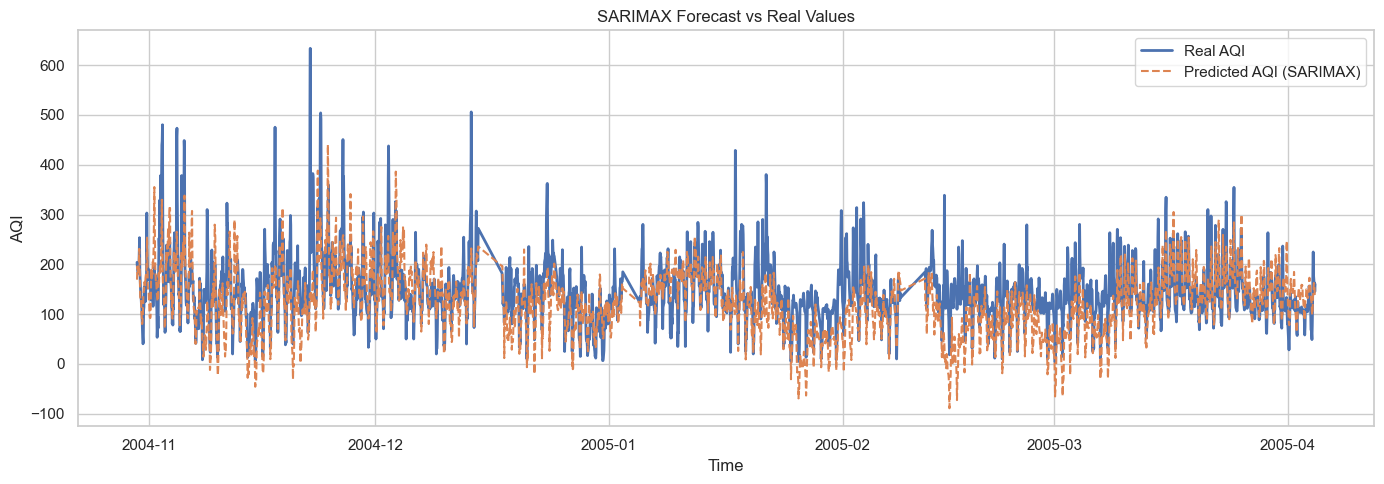

Test RMSE = 59.03
Test MAE  = 45.10


In [48]:
forecast = res.forecast(steps=len(y_test), exog=X_test)

plt.figure(figsize=(14, 5))
plt.plot(time_test.values, y_test.values, label='Real AQI', linewidth=2)
plt.plot(time_test.values, forecast.values, label='Predicted AQI (SARIMAX)', linestyle='--')
plt.title('SARIMAX Forecast vs Real Values')
plt.xlabel('Time')
plt.ylabel('AQI')
plt.legend()
plt.tight_layout()
plt.show()

rmse = np.sqrt(mean_squared_error(y_test, forecast))
mae  = mean_absolute_error(y_test, forecast)
print(f"Test RMSE = {rmse:.2f}")
print(f"Test MAE  = {mae:.2f}")


## 为什么 SARIMAX 的误差反而比 SARIMA 更大？

在我们的实验中，**SARIMA** 仅使用内生序列 **AQI（Y）** 进行估计。  
在数据预处理阶段，我们首先**删除了日期/时间缺失的行**，这会造成时间轴上的**断点**（序列不连续）。随后，由于 **AQI 本身存在缺失值**，我们对 AQI 做了**插值**以补全缺失。最后，为了满足 SARIMA 建模对**规则时间序列**的要求，我们通过 `asfreq("H")` 将数据**重采样为严格按小时（1h）间隔的连续序列**，并对 AQI **再次插值**，从而得到一条**严格连续**的 AQI 序列——这通常更有利于模型估计与预测。

相比之下，**SARIMAX** 由于引入了**外生解释变量（X）**，会带来额外约束：当我们将时间序列补齐到严格的小时网格后，**新补出来的时间点**往往**没有对应的外生变量取值**（例如温度 \(T\) 等）。换言之，为了让时间轴连续而“新增”的行，会导致 **X 出现缺失值**。如果不把所有外生变量也同步到同一小时网格并进行补全/插值，模型就无法在这些时刻形成完整的 \((Y, X)\) 配对，从而影响估计的可行性与质量。

因此，为了确保每个样本点都同时观测到 \((Y, X)\)，我们不得不在 **更接近原始、但不完全连续（时间不规则、信息可能更少）** 的数据上估计 SARIMAX（即不补齐所有时间断点）。这种预处理差异——**SARIMA 在严格连续的序列上建模**，而 **SARIMAX 在更不规则、潜在更不充分的数据上建模**——很可能解释了为什么 **SARIMAX 的误差反而更高**。

## Pourquoi SARIMAX obtient une erreur plus grande que SARIMA ?

Dans notre cas, **SARIMA** est estimé uniquement à partir de la série endogène **AQI (Y)**.  
Lors du prétraitement, nous avons d’abord **supprimé les lignes dont la date/heure était manquante**, ce qui a créé des **ruptures temporelles** (série non continue). Ensuite, comme **AQI contenait des valeurs manquantes**, nous avons **interpolé AQI** pour compléter ces valeurs. Enfin, pour la modélisation SARIMA, nous avons **reconstruit une série horaire régulière** (pas de 1 heure) via `asfreq("H")` et **réinterpolé AQI** afin d’obtenir une **série strictement continue**, condition favorable à l’estimation et à la prévision.

En revanche, pour **SARIMAX**, l’introduction de **variables exogènes (X)** pose une contrainte supplémentaire : après la mise au pas horaire (série complétée), les **nouveaux instants ajoutés** n’ont pas forcément de valeurs disponibles pour les variables explicatives (T, etc.). Autrement dit, les lignes « créées » pour rendre la série continue entraînent des **valeurs manquantes dans X**, ce qui empêche une estimation correcte si l’on ne reconstruit pas également ces variables exogènes sur la même grille horaire.

Par conséquent, nous avons dû estimer SARIMAX sur la **série initiale non parfaitement continue** (sans compléter tous les trous temporels), afin de conserver des couples (Y, X) observés simultanément. Cette différence de traitement — **SARIMA sur une série rendue continue**, versus **SARIMAX sur une série plus irrégulière et potentiellement moins informative** — peut expliquer que **SARIMAX affiche une erreur plus élevée**.


# 随机森林和Boosting RF et Boosting <a id="part3"></a>

##  随机森林 Random forest <a id="part3sec1"></a>


随机森林是一种基于多棵决策树的机器学习方法。每棵树都由随机抽取的数据样本和随机选取的变量子集构建而成，这使得模型之间具有多样性。对于回归问题，最终预测结果是所有树的预测值的平均值。这种方法能够建模变量之间的非线性关系和复杂交互，同时对噪声和过拟合具有较强的稳健性。因此，它特别适用于环境类问题，例如空气质量预测，在这类问题中，变量之间的关系往往很复杂。

Les forêts aléatoires sont une méthode d’apprentissage automatique basée sur un ensemble d’arbres de décision. Chaque arbre est construit à partir d’un échantillon aléatoire des données et d’un sous-ensemble aléatoire de variables, ce qui permet d’introduire de la diversité entre les modèles. Pour un problème de régression, la prédiction finale correspond à la moyenne des prédictions de tous les arbres. Cette méthode est capable de modéliser des relations non linéaires et des interactions complexes entre variables, tout en étant relativement robuste au bruit et au surapprentissage. Elle est donc particulièrement adaptée à des problèmes environnementaux comme la prévision de la qualité de l’air, où les relations entre variables sont souvent complexes.


In [49]:
min_samples_leaf = [5,10, 20, 30, 50, 80]
max_depth = [5, 10, 15, 20, None]
min_samples_split = [20, 30, 50, 80,120]

In [50]:
for mss in min_samples_leaf:
    rf = RandomForestRegressor(
        n_estimators=200,     
        max_depth=None,
        min_samples_leaf=mss,
        random_state=42,
        n_jobs=-1             
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"mss={mss},RMSE:", rmse)
    r2 = r2_score(y_test, y_pred)
    print("R²:", r2)
#我们发现一个性能拐点，即 min_samples_leaf=20
#On trouve un point d'inflexion de la performance min_samples_leaf=20


mss=5,RMSE: 46.712268700681804
R²: 0.40777121878233435
mss=10,RMSE: 46.22697788660355
R²: 0.4200125544534459
mss=20,RMSE: 46.10033452041251
R²: 0.42318606706038464
mss=30,RMSE: 46.135242093740786
R²: 0.4223121993049812
mss=50,RMSE: 46.251356472270636
R²: 0.41940066059547376
mss=80,RMSE: 46.3933953860261
R²: 0.4158291186629465


In [51]:
for mss in min_samples_split:
    rf = RandomForestRegressor(
        n_estimators=200,     
        max_depth=None,
        min_samples_leaf=20,
        min_samples_split=mss,
        random_state=42,
        n_jobs=-1             
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"mss={mss},RMSE:", rmse)
    r2 = r2_score(y_test, y_pred)
    print("R²:", r2)

mss=20,RMSE: 46.10033452041251
R²: 0.42318606706038464
mss=30,RMSE: 46.10033452041251
R²: 0.42318606706038464
mss=50,RMSE: 46.09803953404567
R²: 0.42324349602160916
mss=80,RMSE: 46.08526649757139
R²: 0.42356307192143006
mss=120,RMSE: 46.22735230567575
R²: 0.4200031591068052


In [52]:
rf.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=20, min_samples_split=120,
                      n_estimators=200, n_jobs=-1, random_state=42)

In [53]:
y_pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)
r2 = r2_score(y_test, y_pred)
print("R²:", r2)

RMSE: 46.22735230567575
R²: 0.4200031591068052


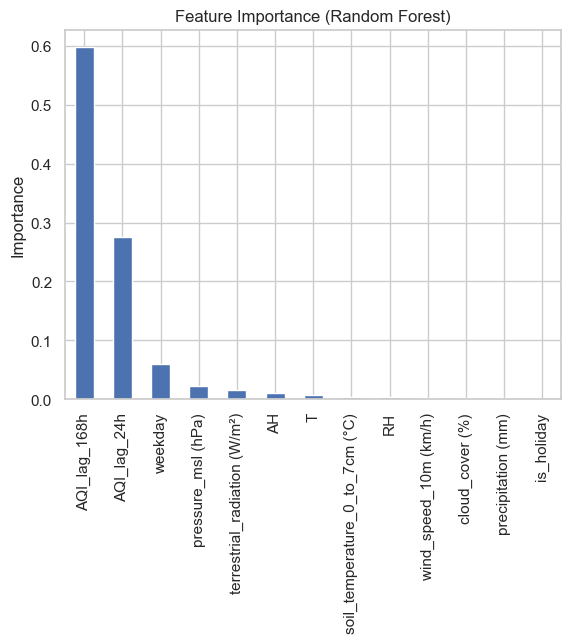

In [54]:
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

feat_imp.plot(kind='bar')
plt.title("Feature Importance (Random Forest)")
plt.ylabel("Importance")
plt.show()


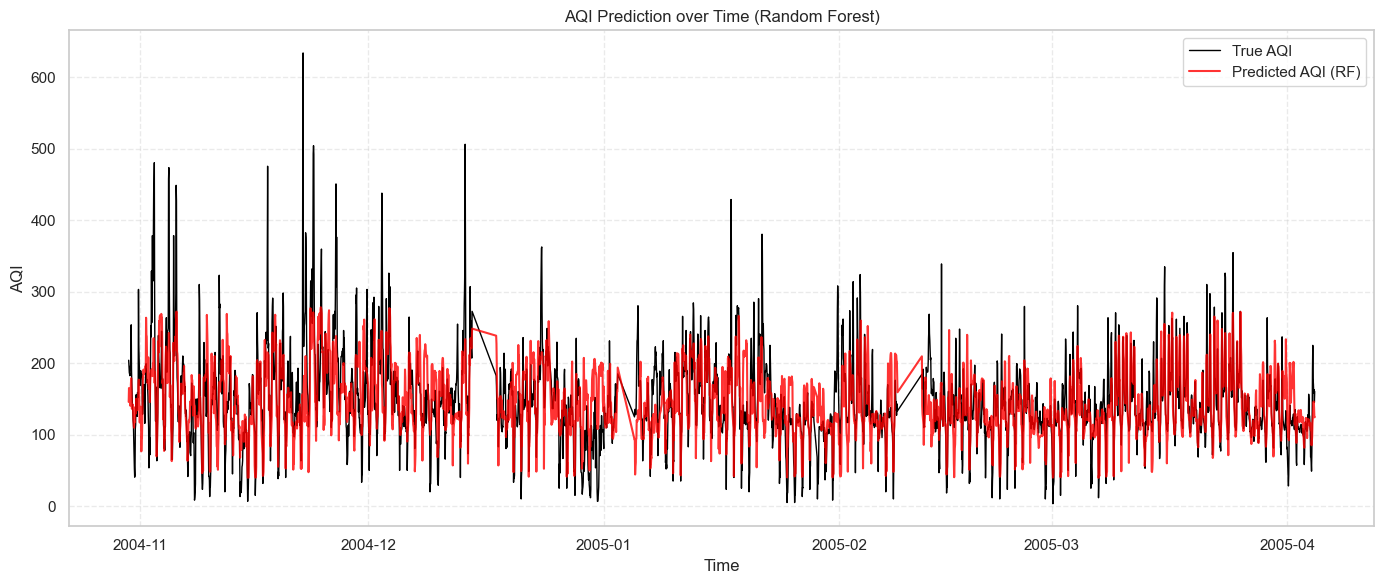

In [55]:
plt.figure(figsize=(14,6))
plt.plot(time_test.values, y_test, label='True AQI', color='black', linewidth=1)
plt.plot(time_test.values, y_pred, label='Predicted AQI (RF)', color='red', alpha=0.8)

plt.title("AQI Prediction over Time (Random Forest)")
plt.xlabel("Time")
plt.ylabel("AQI")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

## 提升法 Boosting <a id="part3sec2"></a>

提升法（Boosting）是一种机器学习方法，其理念是结合多个简单模型（称为 “弱学习器”）来构建一个性能更优的预测模型。与随机森林中树的独立构建不同，提升法以序列方式构建模型：每棵新树都致力于纠正先前模型所犯的错误。在回归问题中，最终预测结果由所有树的预测值加权求和得到。这种方法能够减少模型的偏差，并捕捉复杂的非线性关系。在实际应用中，提升法通常表现出色，尤其适用于像空气质量预测这样的环境问题，但它可能对噪声更敏感，且需要仔细调整参数。

Le boosting est une méthode d’apprentissage automatique fondée sur l’idée de combiner plusieurs modèles simples, appelés « apprenants faibles », pour construire un modèle prédictif plus performant. Contrairement aux forêts aléatoires, où les arbres sont construits indépendamment, le boosting construit les modèles de manière séquentielle : chaque nouvel arbre cherche à corriger les erreurs commises par les modèles précédents. Dans le cas de la régression, les prédictions finales résultent de la somme pondérée des prédictions de tous les arbres. Cette approche permet de réduire le biais du modèle et de capturer des relations non linéaires complexes. Le boosting est souvent très performant en pratique, notamment pour des problèmes environnementaux comme la prévision de la qualité de l’air, mais il peut être plus sensible au bruit et nécessite un réglage soigneux des paramètres.


In [56]:
gbr = GradientBoostingRegressor(
    n_estimators=300,      
    learning_rate=0.05,    
    max_depth=3,           
    random_state=42
)

In [57]:
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

Boosting RMSE: 48.367367450389175
Boosting R²: 0.36506029051724354


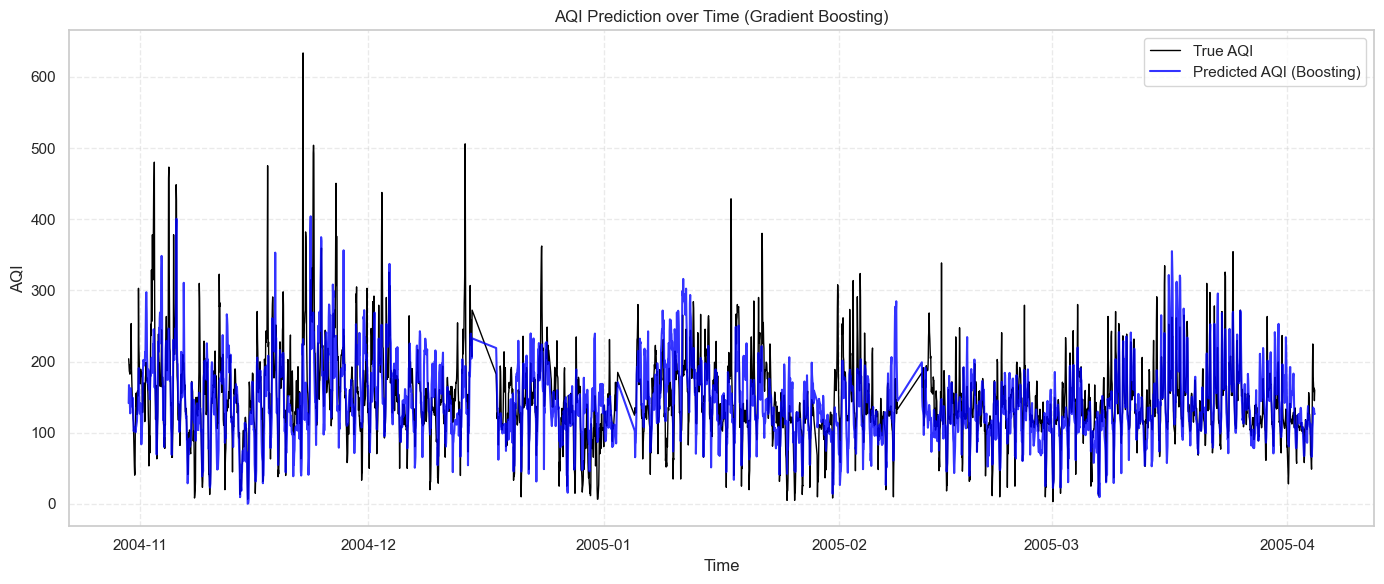

In [58]:
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
r2_gbr = r2_score(y_test, y_pred_gbr)

print("Boosting RMSE:", rmse_gbr)
print("Boosting R²:", r2_gbr)
plt.figure(figsize=(14,6))
plt.plot(time_test.values, y_test, label='True AQI', color='black', linewidth=1)
plt.plot(time_test.values, y_pred_gbr, label='Predicted AQI (Boosting)', color='blue', alpha=0.8)

plt.title("AQI Prediction over Time (Gradient Boosting)")
plt.xlabel("Time")
plt.ylabel("AQI")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


## 袋装法 Bagging <a id="part3sec3"></a>

装袋法（bagging）是一种基于多个模型聚合的机器学习方法，这些模型在数据的随机样本上进行训练。每个模型（通常是决策树）都在通过有放回抽样（自助法）得到的子样本上进行训练。在回归问题中，最终预测是通过对所有模型的预测结果取平均值得到的。这种方法能够减少模型的方差，提高其稳定性，同时不会显著增加偏差。装袋法在基础模型不稳定（如决策树）时特别有用，并且是随机森林等更高级方法的基础。

Le bagging est une méthode d’apprentissage automatique basée sur l’agrégation de plusieurs modèles entraînés sur des échantillons aléatoires des données. Chaque modèle, souvent un arbre de décision, est entraîné sur un sous-échantillon obtenu par tirage avec remise (bootstrap). Les prédictions finales sont obtenues en moyennant les prédictions de tous les modèles dans le cas d’une régression. Cette approche permet de réduire la variance du modèle et d’améliorer sa stabilité sans augmenter fortement le biais. Le bagging est particulièrement utile lorsque le modèle de base est instable, comme les arbres de décision, et constitue la base de méthodes plus avancées comme les forêts aléatoires.


In [59]:
bag = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=None),
    n_estimators=200,      
    max_samples=0.8,       
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)


In [60]:
bag.fit(X_train, y_train)


BaggingRegressor(estimator=DecisionTreeRegressor(), max_samples=0.8,
                 n_estimators=200, n_jobs=-1, random_state=42)

In [61]:
y_pred_bag = bag.predict(X_test)
rmse_bag = np.sqrt(mean_squared_error(y_test, y_pred_bag))
r2_bag = r2_score(y_test, y_pred_bag)

print("Bagging RMSE:", rmse_bag)
print("Bagging R²:", r2_bag)


Bagging RMSE: 47.988424175643516
Bagging R²: 0.3749704265580246


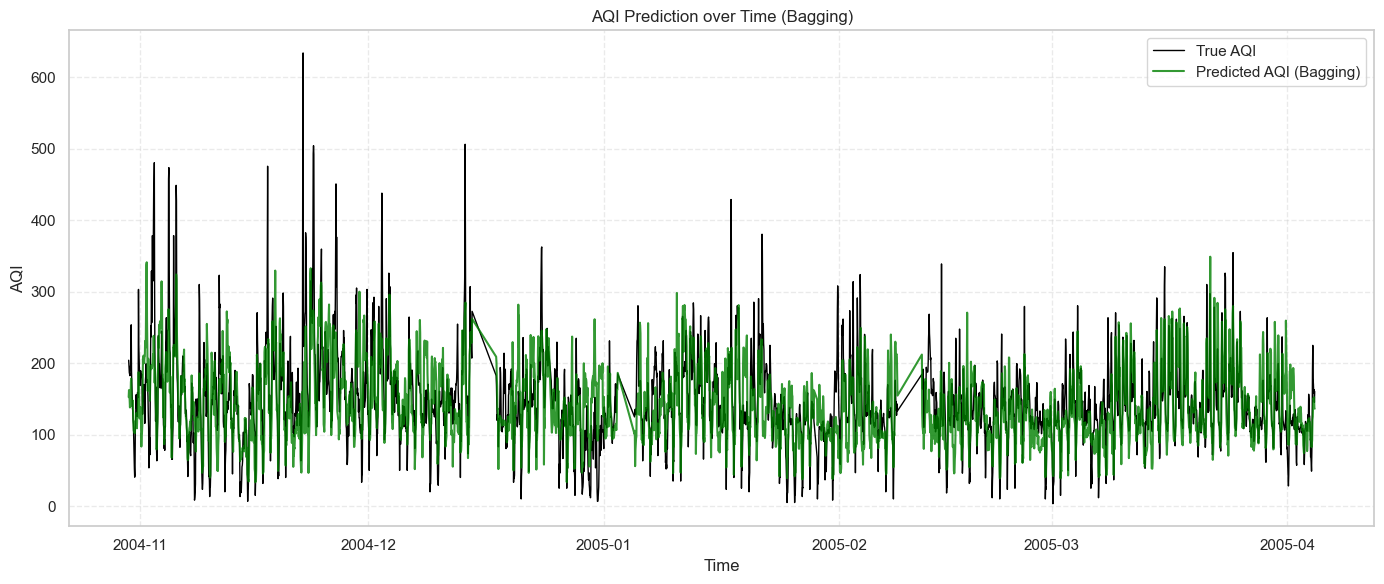

In [62]:
plt.figure(figsize=(14,6))
plt.plot(time_test.values, y_test, label='True AQI', color='black', linewidth=1)
plt.plot(time_test.values, y_pred_bag, label='Predicted AQI (Bagging)', color='green', alpha=0.8)

plt.title("AQI Prediction over Time (Bagging)")
plt.xlabel("Time")
plt.ylabel("AQI")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


## 评价Commentaire <a id="part3sec4"></a>

在这项研究中，我们使用了三种基于决策树的集成方法——Bagging（装袋法）、Random Forest（随机森林）和Boosting（提升法）来预测空气质量指数（AQI）。这三个模型的性能相当接近，且与简单线性回归相比，结果有显著改善，这证实了气象变量与污染之间非线性关系的重要性。其中，Boosting模型的结果略胜一筹，其均方根误差（RMSE）为48.40，决定系数$𝑅^2=0.364$，这意味着它能解释约36%的空气质量指数（AQI）变异性。这种更优的性能得益于其逐步修正误差和捕捉复杂结构的能力，尽管它可能对噪声更为敏感。总体而言，这些结果表明集成方法适用于该问题。

Dans cette étude, nous avons utilisé trois méthodes d’ensemble basées sur des arbres de décision — Bagging, Random Forest et Boosting — pour prédire l’AQI. Les trois modèles montrent des performances assez proches et améliorent nettement les résultats par rapport à une régression linéaire simple, ce qui confirme l’importance des relations non linéaires entre variables météorologiques et pollution. Parmi eux, le modèle Boosting donne des résultats légèrement meilleurs, avec un RMSE de 48,40 et un coefficient de détermination $𝑅^2=0,364$, ce qui signifie qu’il explique environ 36 % de la variabilité de l’AQI. Cette meilleure performance s’explique par sa capacité à corriger progressivement les erreurs et à capturer des structures complexes, même s’il peut être plus sensible au bruit. Globalement, ces résultats montrent que les méthodes d’ensemble sont adaptées à ce problème.

# 神经网络 Réseaux neuroneaux <a id="part4"></a>

本节主要讨论与神经网络相关的模型。它从最基础的多层感知机（MLP）模型开始，以循环神经网络（RNN）框架下的长短期记忆网络（LSTM）/门控循环单元（GRU）模型结束。

我们重新编写训练集-测试集划分来进行训练。

Cette section traite principalement des modèles liés aux réseaux neuronaux. Elle commence par le modèle MLP le plus fondamental et se termine par le modèle LSTM/GRU dans le cadre RNN.

On reécrit le train-test split pour entrainer.

In [63]:
#séparation des ensembles
indices = merged_df.shape[0]
train_idx, test_idx = np.array([i for i in range(0,int(indices*0.6)+1)] ),np.array([i for i in range(int(indices*0.6)+1,indices)] )

X = df_clean.drop(columns=['AQI_interp'], errors='ignore')
X['datetime'] = X['datetime'].view('int64')// 10**9

y = df_cleaned["AQI_interp"]


X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]

#normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Y_train, Y_test= y.iloc[train_idx],y.iloc[test_idx]

## 多层感知机 MLP <a id="part4sec1"></a>

一个前馈神经网络（FNN）模型由 \(L\) 层构成，通过**线性变换**与**非线性变换**的交替组合来实现回归。其定义如下：
\begin{align*}
h_{\theta}^0(x) &= x\,,\\
\text{线性变换}\qquad z_{\theta}^k(x)  &= b^k + W^k h_{\theta}^{k-1}(x)\quad \text{对所有 } 1\leqslant k\leqslant L\,,\\
\text{非线性变换}\qquad h_{\theta}^k(x)  &= \varphi_k\!\big(z_{\theta}^{k}(x)\big)\quad \text{对所有 }1\leqslant k\leqslant L\,,
\end{align*}

其中 \(1 \leqslant k \leqslant L\)，\(b^k\in\mathbb{R}^{d_k}\) 表示第 \(k\) 层的偏置（bias），  
\(W^k\in\mathbb{R}^{d_k\times d_{k-1}}\) 表示第 \(k\) 层的权重矩阵（weights），并令 \(d_0 \equiv d\)。  
\(\varphi_k: \mathbb{R}^{d_k} \to \mathbb{R}^{d_k}\) 是第 \(k\) 层的非线性激活函数（activation function）。

我们将各层输出 \(h_{\theta}^i(x)\)（\(\forall i \in\{1,\dots,L-1\}\)）称为**隐藏层（hidden layers）**，  
并定义最终输出为
\[
f_{\theta}(x) = h_{\theta}^L(x),
\]
在这里 \(f_{\theta}(x)\) 是一个连续函数（continuous function）。


Un FNN modèle est construit par L couches en combinant la transformation linéaire et non linéaire pour faire une regression,
\begin{align*}
h_{\theta}^0(x) &= x\,,\\
\mathrm{Lineaire\; transformation}\qquad z_{\theta}^k(x)  &= b^k + W^kh_{\theta}^{k-1}(x)\quad \mathrm{pour\;tout\;} 1\leqslant k\leqslant L\,,\\
\mathrm{Non-lineaire\; transformation}\qquad h_{\theta}^k(x)  &= \varphi_k(z_{\theta}^{k}(x))\quad \mathrm{pour\;tout\;}1\leqslant k\leqslant L\,,
\end{align*}

avec $1 \leqslant k \leqslant L$, $b^k\in\mathbb{R}^{d_k}$ les biais, $W^k\in\mathbb{R}^{d_k\times d_{k-1}}$ les weights, soit $d_0 \equiv d$, et $\varphi^k: \mathbb{R}^{d_k} \to \mathbb{R}^{d_{k}}$ est d'une fonction non-linéaire d'activation.  
On appelle les couches cachées $h_{\theta}^i(x),\forall i \in\{1 ...L-1\}$ et $f_{\theta}(x) = h_{\theta}^L(x)$ pour le output, ici il est une fonction continue.

In [64]:
## 带有dropout层的模型，以避免过拟合。le modèle avec les couches de dropout pour éviter une overfitting
model_mlp = Sequential([
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)), #ajout de pénalisation
    BatchNormalization(),#normalization
    Dropout(0.2),

    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation='relu'),
    
    Dense(1)   
])

model_mlp.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)



2026-02-12 14:52:05.940292: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2026-02-12 14:52:05.940326: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-02-12 14:52:05.940339: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2026-02-12 14:52:05.940732: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-02-12 14:52:05.941109: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [65]:
# 拟合模型 Fit the model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model_mlp.fit(X_train, Y_train, validation_data = (X_test,Y_test), epochs=50, batch_size=5, verbose=0, callbacks=[early_stop])

2026-02-12 14:52:06.665000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


On définit ensuite les fonctions permettent de visualiser l'entrainement de modèle .

In [66]:
def plot_history(hist):
    """La fonction permet de illustre la variation de la fonction de perte 
    pendant l'entrainement"""
    plt.figure(figsize=(10,8)) 
    fig, axs = plt.subplots(1)
   
    # Error plot
    axs.plot(hist.history["loss"], label="train error")
    axs.plot(hist.history["val_loss"], label="test error")    
    axs.set_ylabel("Error")
    axs.set_xlabel("Epoch")
    axs.legend(loc="upper right")
    axs.set_title("Error eval")
    
    plt.show()

In [67]:
def TrainTestPlot(X_train, X_test, y_test, y_train, model, model_name, NN=True):
    """La fonction permet de entrainer et afficher les erreurs de modèle,
    illustre la prédiction en comparant avec les vraies valeurs"""
    predict_reg = model.predict(X_train)
    predict_test = model.predict(X_test)
    if NN:
        # 如果该模型无法计算误差。 Si la modele ne permet pas de calculer les erreurs. 
        mse = mean_squared_error(predict_test,y_test)
        mae = mean_absolute_error(predict_test,y_test)
        print(f'The Mean Absolute Error of the {model_name} model is: ', mae)
        print('Its Mean Square Error (MSE) is: ', mse)
    else:
        mse, mae = model.evaluate(X_test, y_test, verbose=0)
        print(f'The {model_name} model MSE: {mse}')
        print(f'The {model_name} model MAE: {mae}')


    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1) 
    l_m = np.arange(0, len(y_train))
    plt.figure(1,figsize=(8,5))
    plt.xlabel("Time")
    plt.ylabel('Appliances Consumption')
    plt.plot(l_m,y_train)
    plt.plot(l_m,predict_reg)
    plt.title('Training Set')

    plt.legend(labels=('True Observations','Predicted Observations'))


    plt.subplot(1, 2, 2) 
    l_n = np.arange(0, len(y_test))
    plt.plot(l_n , y_test)
    plt.plot(l_n , predict_test)
    plt.xlabel("Time")
    plt.ylabel('Appliances Consumption')
    plt.legend(labels=('True Observations','Predicted Observations'))
    plt.title('Testing Sets')
    plt.show()

    return mse, mae

In [68]:
def TrainTestPlot_360h(X_train, X_test, y_test, y_train, model, model_name, NN=True):
    """La fonction permet de entrainer et afficher les erreurs de modèle,
    illustre la prédiction en comparant avec les vraies valeurs"""
    predict_reg = model.predict(X_train)
    predict_test = model.predict(X_test)


    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1) 
    l_m = np.arange(0, 360)
    plt.figure(1,figsize=(8,5))
    plt.xlabel("Time")
    plt.ylabel('Appliances Consumption')
    plt.plot(l_m,y_train[:360])
    plt.plot(l_m,predict_reg[:360])
    plt.title('Training Set')

    plt.legend(labels=('True Observations','Predicted Observations'))



    plt.subplot(1, 2, 2) 
    plt.plot(l_m , y_test[:360])
    plt.plot(l_m , predict_test[:360])
    plt.xlabel("Time")
    plt.ylabel('Appliances Consumption')
    plt.legend(labels=('True Observations','Predicted Observations'))
    plt.title('Testing Sets')
    plt.show()
    
    return 0

<Figure size 1000x800 with 0 Axes>

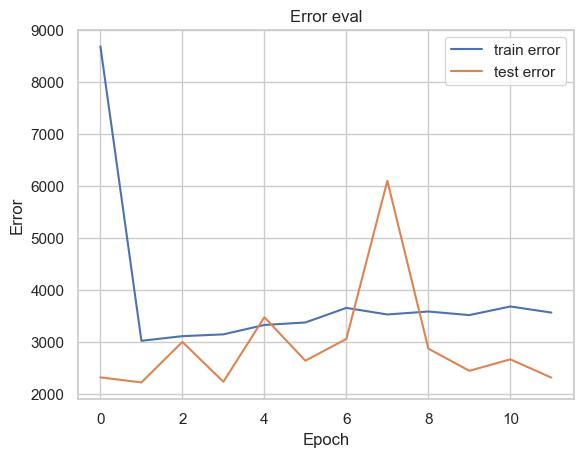

In [69]:
plot_history(history)

166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step   
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
The Dense MLP model MSE: 2224.084716796875
The Dense MLP model MAE: 32.891937255859375


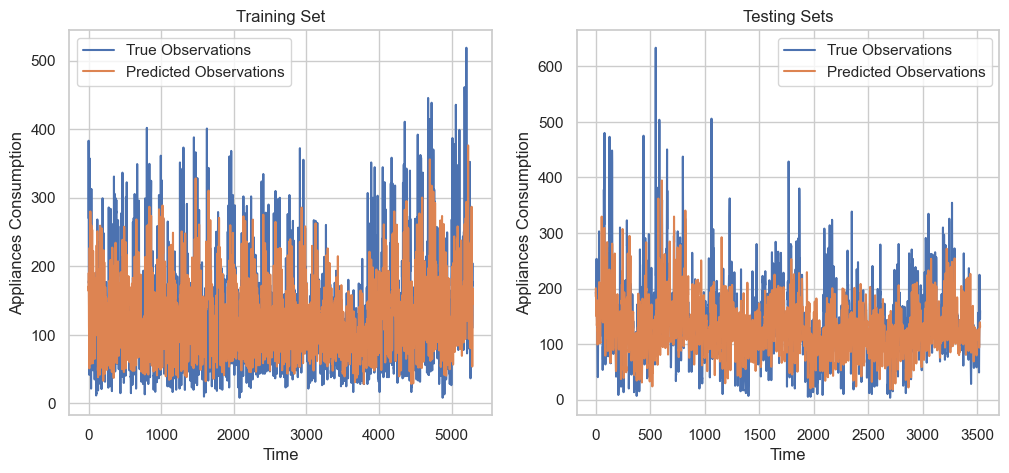

In [70]:
MSE_MLP, MAE_MLP = TrainTestPlot(X_train, X_test, Y_test, Y_train, model_mlp, 'Dense MLP', NN=False)

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


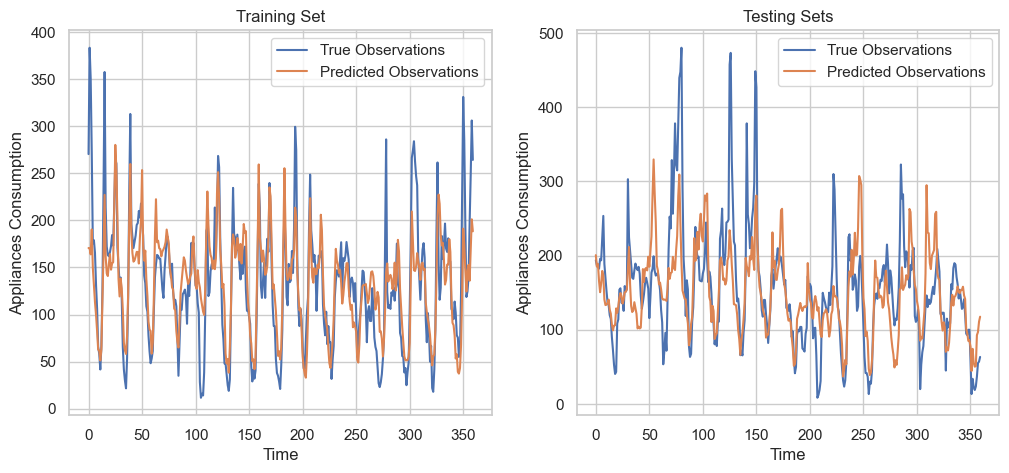

0

In [71]:
TrainTestPlot_360h(X_train, X_test, Y_test, Y_train, model_mlp, 'Dense MLP', NN=False)

多层感知机（MLP）模型的均方误差（MSE）已超过 3000。作为最基础的神经网络模型，多层感知机的构建最为简单。我们仅用三个隐藏层（256、128、64）对其进行了设计，在每层中部署了 20% 比例的激活神经元用于过滤。尽管激活操作旨在防止过拟合，但我们的图表仍显示出了过拟合的趋势。同时，预测中出现了轻微的滞后，这意味着今天的预测与前两天的数值变化更为相符。这一结果可能是由于模型依赖前 24 小时的数据所导致的。

L'erreur quadratique moyenne (MSE) du modèle MLP a atteint plus que 3000. En tant que modèle de réseau neuronal le plus fondamental, la construction d'un MLP est la plus simple. Nous l'avons conçu avec seulement trois couches cachées (256, 128, 64), en déployant une proportion de 0,2 de neurones activés dans chaque couche pour le filtrage. Bien que l'activation vise à prévenir le surajustement, nos graphiques présentent toujours des tendances au surajustement. Parallèlement, un léger retard apparaît dans les prévisions, ce qui signifie que les prévisions d'aujourd'hui correspondent davantage aux changements numériques des deux jours précédents. Ce résultat provient probablement du fait qu'il s'appuie sur les données des 24 heures précédentes.


## 循环神经网络和长短期记忆网络RNN & LSTM <a id="part4sec2"></a>


LSTM（Long Short-Term Memory，**长短期记忆网络**）是循环神经网络（RNN）的一种改进版本，旨在更好地处理序列数据中的**长期依赖**问题。其核心特点是在每个时间步引入三种门控机制——**遗忘门（forget gate）**、**输入门（input gate）**与**输出门（output gate）**——用来调节信息在网络中的流动。这些门决定哪些信息应被保留、遗忘或写入到记忆状态中。

其中，细胞状态（cell state）\({c}^k(x)\) 可视为**长期记忆**的载体，而隐藏状态（hidden state）\({h}^k(x)\) 则作为当前时间步的**即时输出**。每个门通常对输入与上一时刻隐藏状态的线性组合施加 **Sigmoid** 函数，以产生 \([0,1]\) 的门控系数；细胞状态的候选更新使用 \(\tanh(\cdot)\) 激活以稳定数值范围。借助这一机制，LSTM 能在长序列中更有效地保留关键信息，因此常在**时间序列预测**、**语言建模**等任务中优于传统 RNN。

最终，LSTM 的计算可写为如下形式：
\begin{align*}
h_{\theta}^0(x) &= x\,,\\
\text{并且}\qquad f^k(x)  &=\sigma_g (W_f x_k +U_f h_{k-1}+b_f) \\
\qquad i^k(x)  &=\sigma_g (W_i x_k +U_i h_{k-1}+b_i) \\
\qquad o^k(x)  &=\sigma_g (W_o x_k +U_o h_{k-1}+b_o) \\
\qquad \hat{c}^k(x)  &=\tanh_c (W_c x_k +U_c h_{k-1}+b_c) \\
\qquad {c}^k(x)  &=f^k(x)\odot{c}^{k-1}(x) +i^k(x) \odot \hat{c}^k(x)\\
\qquad h_{\theta}^k(x)  &= o^k(x) \odot \sigma_h ({c}^k(x))\quad \text{对所有 }1\leqslant k\leqslant L\,,
\end{align*}

其中各符号含义为：

- \(f^k(x)\)：**遗忘门（forget gate）**  
- \(i^k(x)\)：**输入门（input gate）**  
- \(o^k(x)\)：**输出门（output gate）**  
- \(\hat{c}^k(x)\)：**候选细胞输入激活向量**（cell input activation vector）  
- \({c}^k(x)\)：**细胞状态向量**（cell state vector）  
- \({h}^k(x)\)：**隐藏状态/隐藏层输出**（hidden state / hidden layer）  
- \(W, U\)：**权重矩阵**（weight matrices），\(b\)：**偏置向量**（bias vectors）  
- \(\sigma_g\)：**Sigmoid 函数**（sigmoid function）  
- \(\sigma_h\)：**双曲正切函数**（hyperbolic tangent function, \(\tanh\)）  
- \(\odot\)：**Hadamard 逐元素乘法**（element-wise product）


Le modèle LSTM (Long Short-Term Memory) est une version avancée des réseaux neuronaux récurrents, conçue pour mieux gérer les dépendances à long terme dans les données séquentielles. Il se distingue par l’introduction de trois portes — d’entrée, de sortie et d’oubli — qui régulent le flux d'information à chaque pas temporel. Ces portes déterminent quelles informations doivent être conservées, oubliées ou ajoutées à l’état de mémoire. L'état de cellule ${c}^k(x)$ joue le rôle de mémoire à long terme, tandis que l'état caché ${h}^k(x)$ agit comme sortie immédiate. Chaque porte applique une fonction sigmoïde aux combinaisons linéaires des entrées et des états précédents, et la mise à jour de la cellule utilise une activation $\tanh(x)$ pour stabiliser les valeurs. Grâce à ce mécanisme, les LSTMs parviennent à conserver l'information pertinente sur de longues séquences, surpassant ainsi les RNNs classiques dans des tâches comme la prédiction de séries temporelles ou la modélisation du langage.


Finalement il est sous la forme suivant :
\begin{align*}
h_{\theta}^0(x) &= x\,,\\
et
\qquad f^k(x)  &=\sigma_g (W_f x_k +U_f h_{k-1}+b_f) \\
\qquad i^k(x)  &=\sigma_g (W_i x_k +U_i h_{k-1}+b_i) \\
\qquad o^k(x)  &=\sigma_g (W_o x_k +U_o h_{k-1}+b_o) \\
\qquad \hat{c}^k(x)  &=\tanh_c (W_c x_k +U_c h_{k-1}+b_c) \\
\qquad {c}^k(x)  &=f^k(x)\odot{c}^{k-1}(x) +i^k(x) \odot \hat{c}^k(x)\\
\qquad h_{\theta}^k(x)  &= o^k(x) \odot \sigma_h ({c}^k(x))\quad \mathrm{pour\;tout\;}1\leqslant k\leqslant L\,,
\end{align*}
avec :  
$f^k(x) : \mathrm{forget\; gate}$   
$i^k(x) : \mathrm{input\; gate}$   
$o^k(x) : \mathrm{output\; gate}$   
$\hat{c}^k(x) : \mathrm{cell\; input\; activation\; vector}$  
${c}^k(x) : \mathrm{cell\; state\; vector}$  
${h}^k(x) : \mathrm{hidden\; layer}$  
$W,U\; \mathrm{weight \;matrix}\; \& \;b \;\mathrm{bais \;vector} $  
$\sigma_g : \mathrm{sigmoid\; fonction}$  
$\sigma_h : \mathrm{hyperbolic \;tangent \;function}$  

In [72]:
#为了应用长短期记忆网络（LSTM），我们需要将数据重塑为一个三维数组，以明确模型的时间特征，并让模型能够从中学习。Afin d'appliquer le LSTM, nous devons remodeler les données en un tableau 3D afin de spécifier
# les caractéristiques temporelles du modèle et lui permettre d'apprendre à partir de celles-ci. 

#将数据转换为三维格式（样本数、时间步长、特征数） Convert Data to 3D Format (samples, time steps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(f"LSTM train dataset: {X_train_lstm.shape}")
print(f"LSTM test dataset : {X_test_lstm.shape}")

LSTM train dataset: (5294, 1, 14)
LSTM test dataset : (3529, 1, 14)


In [73]:
# Recherche aléatoire pour l'optimisation des hyperparamètres
# Ce code est utilisé pour trouver les meilleurs hyperparamètres en appliquant une recherche aléatoire.
# Le code est commenté afin de ne pas être réexécuté pendant les tests. La meilleure piste a été partagée avec la soumission finale et peut être exécutée si elle est enregistrée dans le même dossier que le fichier actuel.
'''用于超参数优化的随机搜索
此代码用于通过应用随机搜索来找到最佳超参数。代码已被注释，以避免在测试过程中被重复执行。最佳结果对应的版本已随最终提交一并提供；只要将其保存在与当前文件相同的文件夹中，即可直接运行。
'''

model_storage_folder = "LSTM_Hyperparameters"

# RandomSearch pour Hyperparameters Optimisation
def build_model(hp):
    model = keras.Sequential([
        layers.LSTM(hp.Int('units1', min_value=32, max_value=1024, step=64), 
                    activation='tanh', 
                    return_sequences=True,  
                    input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        layers.BatchNormalization(),
        layers.LSTM(hp.Int('units2', min_value=32, max_value=256, step=32), 
                    activation='tanh', 
                    return_sequences=False),
        layers.Dropout(0.2),
        layers.Dense(hp.Int('units2', min_value=16, max_value=512, step=32), activation='relu'),
        layers.Dense(hp.Int('units2', min_value=16, max_value=128, step=16), activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(hp.Int('units3', min_value=16, max_value=64, step=16), activation='relu'),
        layers.Dense(hp.Int('units3', min_value=8, max_value=32, step=8), activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
                  loss='mse', metrics=['mae'])
    return model

# 已注释代码（COMMENTED CODE）

# 取消注释可从 0 重新训练模型
# shutil.rmtree(model_storage_folder, ignore_errors=True)  # 删除模型/调参结果的存储目录（若存在则忽略错误）
# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# tuner = kt.RandomSearch( build_model, objective='val_loss',max_trials=20,directory=model_storage_folder, project_name="hyperparameter_tuning")
# tuner.search( X_train_lstm, Y_train,epochs=50,validation_data=(X_test_lstm, Y_test),callbacks=[early_stop])

#COMMENTED CODE

#Uncomment to re-train the model from 0
# shutil.rmtree(model_storage_folder, ignore_errors=True)
# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# tuner = kt.RandomSearch(build_model, objective='val_loss', max_trials=20,  directory=model_storage_folder, project_name="hyperparameter_tuning")
# tuner.search(X_train_lstm, Y_train, epochs=50, validation_data=(X_test_lstm, Y_test), callbacks=[early_stop])




In [74]:
#最佳路径提取
#如需加载超参数
#EXTRACTION OF BEST TRAIL

# Load hyperparameters if needed
best_hps_dict = {"units1": 352, "units2": 64, "units3": 48, "learning_rate": 0.0001}

print("Loaded best hyperparameters:")
print(best_hps_dict)

Loaded best hyperparameters:
{'units1': 352, 'units2': 64, 'units3': 48, 'learning_rate': 0.0001}


In [75]:
def build_model_from_dict2(hp_dict):
    model = keras.Sequential([
        layers.LSTM(units=hp_dict['units1'],activation='tanh', return_sequences=True,input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        layers.BatchNormalization(),
        layers.LSTM(units=hp_dict['units2'], activation='tanh',return_sequences=False),
        layers.Dropout(0.2),
        layers.Dense(hp_dict['units2'], activation='relu'),
        layers.Dense(hp_dict['units2'], activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(hp_dict['units3'], activation='relu'),
        layers.Dense(hp_dict['units3'], activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(hp_dict['learning_rate']),
        loss='mse',
        metrics=['mae']
    )
    return model


best_model = build_model_from_dict2(best_hps_dict)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = best_model.fit(X_train_lstm, Y_train, epochs=100, validation_data=(X_test_lstm, Y_test), callbacks=[early_stop], verbose=0)


<Figure size 1000x800 with 0 Axes>

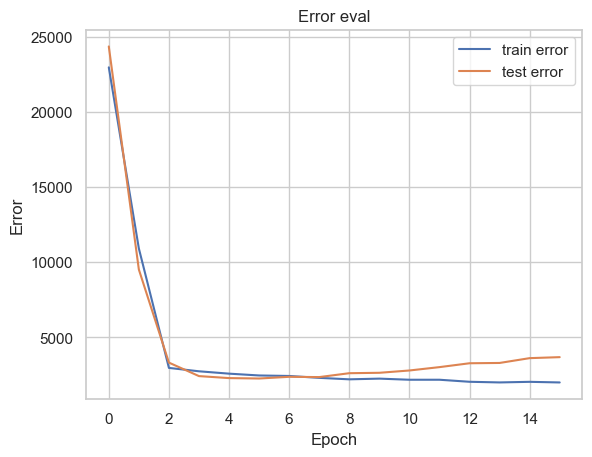

In [76]:
plot_history(history)

166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step   
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
The LSTM with RandomSearch model MSE: 2260.19970703125
The LSTM with RandomSearch model MAE: 33.91056442260742


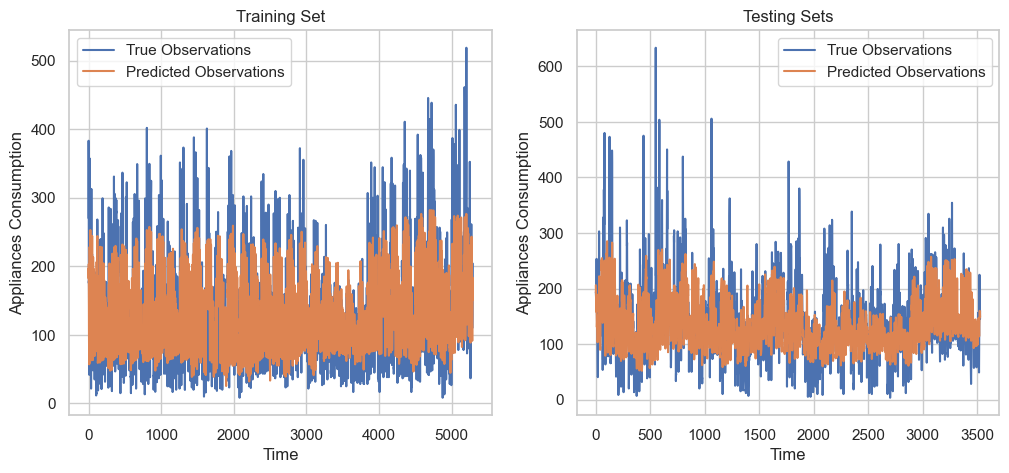

In [77]:
MSE_LSTM_RS, MAE_LSTM_RS = TrainTestPlot(X_train_lstm, X_test_lstm, Y_test, Y_train, best_model, 'LSTM with RandomSearch', NN=False)

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


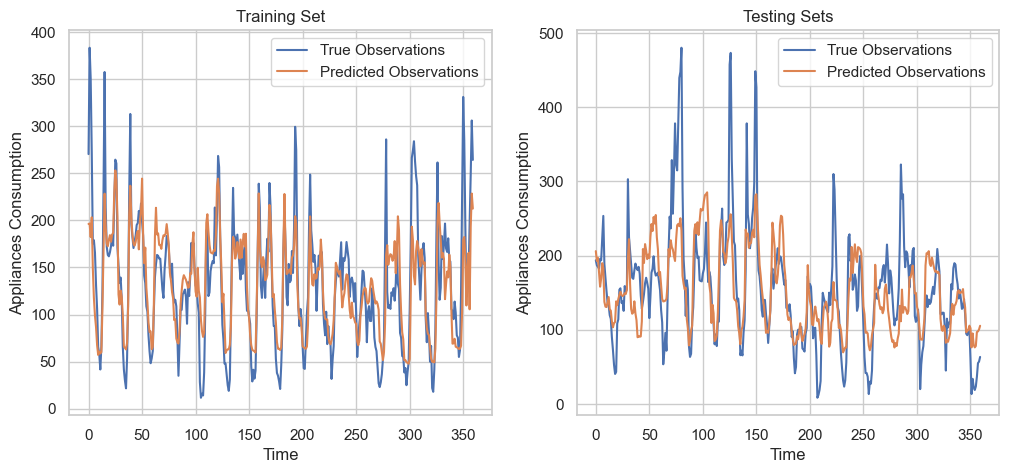

0

In [78]:
TrainTestPlot_360h(X_train_lstm, X_test_lstm, Y_test, Y_train, best_model, 'LSTM with RandomSearch', NN=False)

LSTM 的均方误差（MSE）达到了 2300，这与多层感知器（MLP）相比有了显著改善。LSTM 的超参数是通过 Keras Tuner 的随机梯度下降法获得的，这一过程仍是一个难以解释的黑箱。关于两周内的数据波动，LSTM 的预测比 MLP 更为保守。它降低了历史数据的参考价值，同时几乎无法预测最大值。该模型没有提供具体的预测，而是似乎在指示潜在趋势。尽管 LSTM 能够预示空气质量的改善或恶化，但要精确确定空气质量等级仍然很困难。

L'erreur MSE pour le LSTM a atteint 2300, ce qui représente une nette amélioration par rapport au MLP. Les hyperparamètres du LSTM ont été obtenus grâce à l'apprentissage par descente stochastique des gradients par Keras Tuner, un processus qui reste une boîte noire et difficile à expliquer. En ce qui concerne les fluctuations des données sur la période de deux semaines, les prévisions du LSTM se sont révélées plus prudentes que celles du MLP. Il a réduit la valeur de référence des données historiques tout en n'offrant pratiquement aucune prévision des valeurs maximales. Plutôt que de fournir des prévisions spécifiques, le modèle semble indiquer les tendances sous-jacentes. Si le LSTM peut signaler des améliorations ou des détériorations de la qualité de l'air, il reste difficile de déterminer avec précision les niveaux de qualité.


##  循环神经网络 & 门控循环单元 RNN & GRU <a id="part4sec3"></a>


GRU（Gated Recurrent Unit，**门控循环单元**）是 LSTM 的一种简化变体，在保留长程记忆能力的同时降低了模型复杂度。它主要包含两类门控机制：**更新门（update gate）** \(z^k\)，用于控制上一时刻状态有多少需要被保留；以及**重置门（reset gate）** \(r^k\)，用于决定需要“遗忘”多少过去信息。

与 LSTM 不同，GRU **没有单独的细胞状态（cell state）**：其隐藏状态 \(h^k\) 直接在上一时刻的状态与候选状态 \(\hat{h}^k\) 之间进行加权融合，权重由 \(z^k\) 学习得到。由于结构更紧凑，GRU 往往训练更快，同时在许多时间序列预测或自然语言处理任务中能取得与 LSTM 相近的性能。

\begin{align*}
\qquad z^k(x)  &=\sigma_g (W_z x_k +U_f h_{k-1}+b_z) \\
\qquad r^k(x)  &=\sigma_g (W_r x_k +U_i h_{k-1}+b_r) \\
\qquad \hat{h}^k(x)  &=\sigma_h (W_h x_k +U_o (r^k \odot h_{k-1})+b_h) \\
\qquad h^k(x)  &= (1-z^k) \odot h_{k-1} + z^k \odot \hat{h}^k
\end{align*}

其中：

- \(z^k\)：**更新门（update gate）**  
- \(r^k\)：**重置门（reset gate）**  
- \(\hat{h}^k\)：**候选激活向量**（candidate activation vector）  
- \(x_k\)：**输入向量**（input vector）  
- \(h^k\)：**输出/隐藏状态向量**（output/hidden state vector）  
- \(W, U\)：**权重矩阵**（weight matrices），\(b\)：**偏置向量**（bias vectors）  
- \(\sigma_g\)：**Sigmoid 函数**（sigmoid function）  
- \(\sigma_h\)：**双曲正切函数**（hyperbolic tangent function, \(\tanh\)）  
- \(\odot\)：**逐元素乘法**（element-wise product）

---

## 使用 OPTUNA 进行超参数优化

我们将使用 **OPTUNA** 进行超参数优化。OPTUNA 是一个超参数优化库，采用**智能采样**（常见为贝叶斯优化等思想）来高效搜索超参数空间。它会在搜索过程中，根据已测试的参数组合与对应表现，逐步建立“超参数 → 性能”的概率模型。

在每一次迭代中，OPTUNA 会优先选择**最有希望提升目标指标**的超参数组合进行试验，从而在较少的试验次数下，就能快速逼近最优配置。优化目标通常是最大化或最小化某个指标，例如**验证集损失（validation loss）**。这种方法尤其适合维度高、搜索空间复杂的调参问题。

(Gated Recurrent Unit) est une variante simplifiée du LSTM, qui conserve l’efficacité de la mémoire tout en réduisant la complexité du modèle. Il utilise deux portes principales : la porte de mise à jour (*update gate*) $z^k$, qui contrôle la part de l’état précédent à conserver, et la porte de réinitialisation (*reset gate*) $r^k$, qui décide combien d’information passée doit être oubliée. Contrairement au LSTM, le GRU ne possède pas de vecteur de cellule distinct : son état caché $h^k$ combine directement l’état précédent et un vecteur candidat $\hat{h}^k$, selon les pondérations apprises via $z^k$. Ce mécanisme plus compact permet un entraînement plus rapide, tout en offrant des performances comparables aux LSTM dans de nombreuses tâches de séries temporelles ou de traitement du langage.
  
\begin{align*}
\qquad z^k(x)  &=\sigma_g (W_z x_k +U_f h_{k-1}+b_z) \\
\qquad r^k(x)  &=\sigma_g (W_r x_k +U_i h_{k-1}+b_r) \\
\qquad \hat{h}^k(x)  &=\sigma_h (W_h x_k +U_o (r^k \odot h_{k-1})+b_h) \\
\qquad h^k(x)  &= (1-z^k) \odot h_{k-1} + z^k \odot \hat{h}^k
\end{align*}
avec :  
$z^k : \mathrm{update\; gate}$   
$r^k : \mathrm{reset\; gate}$   
$\hat{h}^k : \mathrm{candidate \;activation \;vector}$  
${x}^k : \mathrm{input\; vector}$  
${h}^k : \mathrm{output\; vector}$  
$W,U\; \mathrm{weight \;matrix}\; \& \;b \;\mathrm{bais \;vector} $  
$\sigma_g : \mathrm{sigmoid\; fonction}$  
$\sigma_h : \mathrm{hyperbolic \;tangent \;function}$  

On va utiliser OPTUNA, une bibliothèque d’optimisation d’hyperparamètres qui utilise une approche basée sur l’échantillonnage intelligent, souvent via des méthodes bayésiennes. Elle fonctionne en explorant automatiquement l’espace de recherche des hyperparamètres, en construisant un modèle de probabilité des performances en fonction des valeurs testées. À chaque itération, OPTUNA sélectionne les combinaisons les plus prometteuses à tester, en maximisant ou minimisant une métrique cible (comme la perte de validation). Cette approche permet de trouver rapidement des configurations optimales, même dans des espaces de recherche complexes.

In [79]:
# Define the objective function
def objective(trial):
    units1 = trial.suggest_int('units1', 128, 1024, step=64)
    units2 = trial.suggest_int('units2', 64, 512, step=32)
    units3 = trial.suggest_int('units3', 64, 512, step=32)
    units4 = trial.suggest_int('units4', 32, 256, step=32)
    units5 = trial.suggest_int('units5', 32, 256, step=16)
    units6 = trial.suggest_int('units6', 16, 256, step=16)
    units7 = trial.suggest_int('units7', 16, 128, step=16)
    units8 = trial.suggest_int('units8', 16, 128, step=16)

        
    recurrent_dropout_rate = trial.suggest_float('recurrent_dropout_rate', 0.1, 0.2, step=0.01)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    dropout_rate1 = trial.suggest_float('dropout_rate1', 0.4, 0.65, step=0.05)
    dropout_rate2 = trial.suggest_float('dropout_rate2', 0.4, 0.65, step=0.05)
    dropout_rate3 = trial.suggest_float('dropout_rate3', 0.4, 0.65, step=0.05)
    dropout_rate4 = trial.suggest_float('dropout_rate4', 0.4, 0.65, step=0.05)
    learning_rate = trial.suggest_categorical('learning_rate', [0.0005, 0.0004, 0.0003, 0.0002, 0.0001])

    
    # Build the model
    model = keras.Sequential([
        layers.Bidirectional(layers.GRU(units1, activation='tanh', return_sequences=True, recurrent_dropout=recurrent_dropout_rate,input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))),
        layers.BatchNormalization(),
        layers.GRU(units2, activation='tanh', return_sequences=True, recurrent_dropout=recurrent_dropout_rate),
        layers.Dropout(dropout_rate1),

        layers.Bidirectional(layers.GRU(units3, activation='tanh', return_sequences=True, recurrent_dropout=recurrent_dropout_rate)),
        layers.BatchNormalization(),
        layers.GRU(units4, activation='tanh', return_sequences=True, recurrent_dropout=recurrent_dropout_rate),
        layers.Dropout(dropout_rate2),

        layers.Bidirectional(layers.GRU(units5, activation='tanh', return_sequences=True, recurrent_dropout=recurrent_dropout_rate)),
        layers.BatchNormalization(),
        layers.GRU(units6, activation='tanh', return_sequences=False, recurrent_dropout=recurrent_dropout_rate),
        layers.Dropout(dropout_rate3),

        layers.Dense(units7, activation='relu'),
        layers.Dense(units8, activation='relu'),
        layers.Dropout(dropout_rate4),
        layers.Dense(1, activation='linear')
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='mse', metrics=['mae'])
    
    # Train model
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0)
    
    history = model.fit(X_train_lstm, Y_train, epochs=100, validation_data=(X_test_lstm, Y_test),
                        callbacks=[early_stop, reduce_lr], verbose=0, batch_size=batch_size)
    
    return min(history.history['val_loss'])


In [80]:
#不要运行此代码，因为它会搜索一个新的改进模型。而是使用下面已定义的模型
#注释的代码
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=25)
#避免运行此代码，以免重新训练任何模型。最佳超参数已存储在下面的变量中。
#Do not run this code, as it will search for a new imporoved , model. Rather use the ones already defined below

#COMMENTED CODE

# study = optuna.create_study(direction='minimize') 
# study.optimize(objective, n_trials=25)  

# Avoid running this code as not to re-train any model.The best hyperparameters have been stored in the varables below.

In [81]:
best_params = {'units1': 192, 'units2': 96, 'units3': 352, 'units4': 128, 'units5': 176, 'units6': 160, 'units7': 32, 'units8': 128, 'recurrent_dropout_rate': 0.14, 'batch_size': 128, 'dropout_rate1': 0.5, 'dropout_rate2': 0.4, 'dropout_rate3': 0.6000000000000001, 'dropout_rate4': 0.55, 'learning_rate': 0.0003}

In [82]:
best_modelGRU = keras.Sequential([
    layers.Bidirectional(layers.GRU(best_params['units1'], activation='tanh', return_sequences=True, recurrent_dropout=best_params['recurrent_dropout_rate'],input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))),
    layers.BatchNormalization(),
    layers.GRU(best_params['units2'], activation='tanh', return_sequences=True, recurrent_dropout=best_params['recurrent_dropout_rate']),
    layers.Dropout(best_params['dropout_rate1']),

    layers.Bidirectional(layers.GRU(best_params['units3'], activation='tanh', return_sequences=True, recurrent_dropout=best_params['recurrent_dropout_rate'])),
    layers.BatchNormalization(),
    layers.GRU(best_params['units4'], activation='tanh', return_sequences=True, recurrent_dropout=best_params['recurrent_dropout_rate']),
    layers.Dropout(best_params['dropout_rate2']),

    layers.Bidirectional(layers.GRU(best_params['units5'], activation='tanh', return_sequences=True, recurrent_dropout=best_params['recurrent_dropout_rate'])),
    layers.BatchNormalization(),
    layers.GRU(best_params['units6'], activation='tanh', return_sequences=False, recurrent_dropout=best_params['recurrent_dropout_rate']),
    layers.Dropout(best_params['dropout_rate3']),

    layers.Dense(best_params['units7'], activation='relu'),
    layers.Dense(best_params['units8'], activation='relu'),
    layers.Dropout(best_params['dropout_rate4']),
    layers.Dense(1, activation='linear')
])

# Compile with best learning rate
best_modelGRU.compile(optimizer=keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
                   loss='mse', metrics=['mae'])

# Train the model
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0)

history = best_modelGRU.fit(X_train_lstm, Y_train, epochs=100, validation_data=(X_test_lstm, Y_test), callbacks=[early_stop, reduce_lr], verbose=0, batch_size=best_params['batch_size'])


<Figure size 1000x800 with 0 Axes>

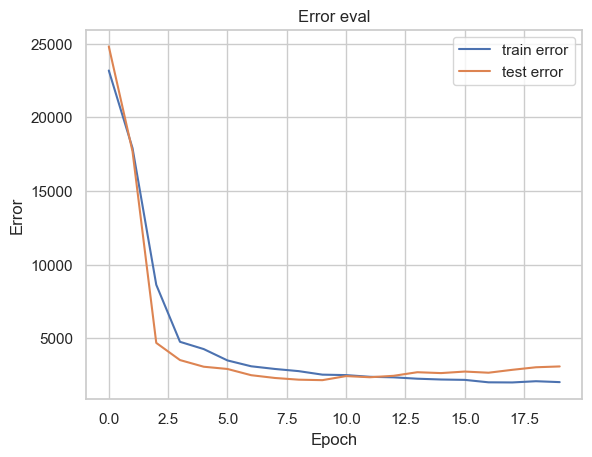

In [83]:
plot_history(history)

166/166 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
The GRU with OPTUNA model MSE: 2158.959716796875
The GRU with OPTUNA model MAE: 31.840377807617188


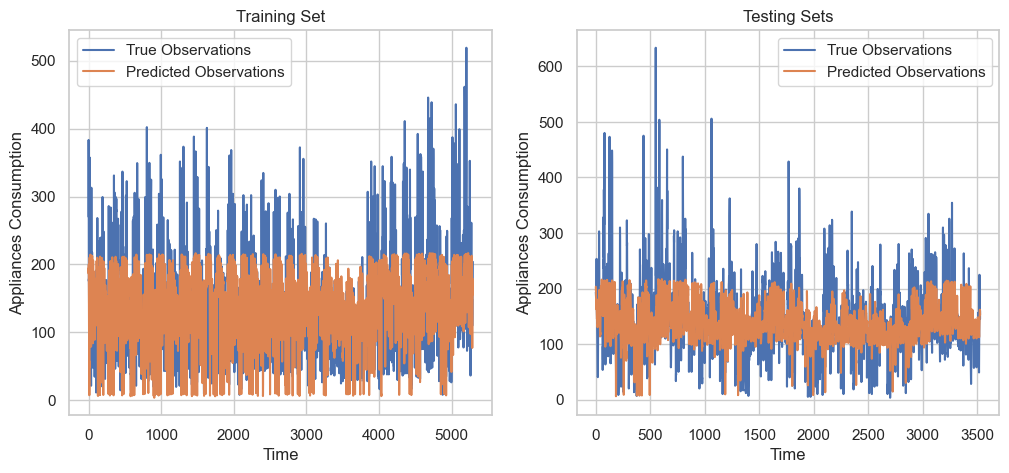

In [84]:
MSE_GRU_FT, MAE_GRU_FT = TrainTestPlot(X_train_lstm, X_test_lstm, Y_test, Y_train, best_modelGRU, 'GRU with OPTUNA', NN=False)

166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


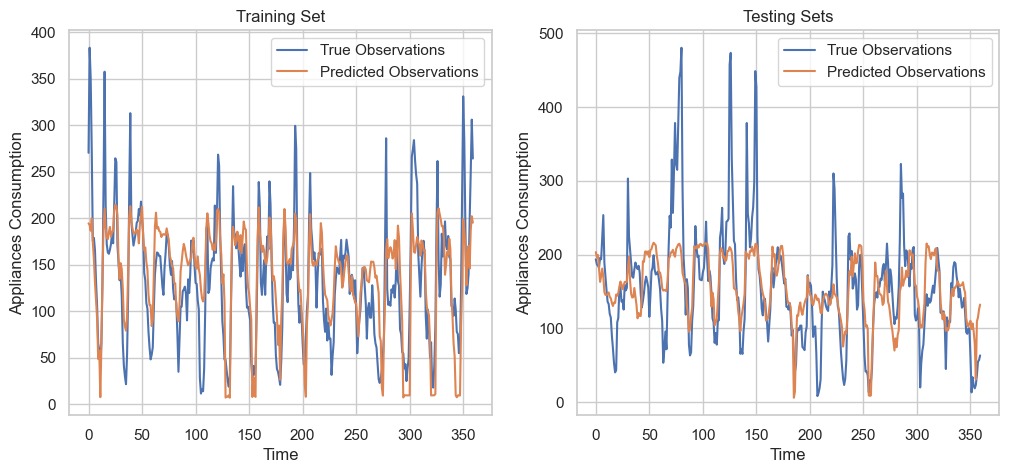

0

In [85]:
TrainTestPlot_360h(X_train_lstm, X_test_lstm, Y_test, Y_train, best_modelGRU, 'GRU with OPTUNA', NN=False)

GRU 的均方误差（MSE）低于 LSTM，达到 2200。作为 LSTM 的变体，其性能并不明显优于 LSTM。此外，它在峰值预测方面表现出与 LSTM 相似的特征。这两种模型在稳定范围内往往会做出相对保守的预测。该范围内的值会产生有利的预测结果，而超出该范围的数据则会被忽略。GRU 的优势在于其更固定的范围以及在该范围内更出色的预测能力。这一结果也与模型的深度有关。

Le GRU présente une erreur MSE inférieure à celle du LSTM, atteignant 2200. En tant que variante du LSTM, ses performances ne sont pas nettement supérieures à celles du LSTM. De plus, il présente des caractéristiques similaires à celles du LSTM dans la prédiction des pics. Les deux modèles ont tendance à faire des prédictions relativement prudentes dans une fourchette stable. Les valeurs comprises dans cette fourchette donnent lieu à des prédictions favorables, tandis que les données en dehors de cette fourchette sont ignorées. L'avantage du GRU réside dans sa plage plus fixe et ses prévisions supérieures dans cette plage. Ce résultat est également lié à la profondeur du modèle.

# 总结 Conlusion <a id="part5"></a>

 由于数据集中存在缺失数据，且后续线性插值的影响有限，空气质量指数（AQI）的变化可能并不一定与实际情况相符。此外，缺乏地理定位信息意味着额外的环境变量可能无法直接关联。数据集的固有性质使得最终结果难以预测。

 在性能方面，SARIMA模型表现出较高的精度，SARIMAX表现不佳，原因是因为未在连续时间序列上进行拟合模型。而与随机森林（RF）相关的方法结果则高度收敛。多层感知器（MLP）在时间序列方面的感知能力较弱，长短期记忆网络（LSTM）和门控循环单元（GRU）均对极端值的变化不敏感。尽管如此，所有模型都成功预测了数值变化的总体趋势，这使得它们在参考用途上非常有用。这种趋势使我们能够发出相关的早期警报。

 En raison des données manquantes dans l'ensemble de données et de l'impact partiel de l'interpolation linéaire ultérieure, les changements dans l'indice de qualité de l'air (AQI) peuvent ne pas nécessairement correspondre à la réalité. De plus, l'absence d'informations sur la localisation géographique signifie que les variables environnementales supplémentaires peuvent ne pas être directement corrélées. La nature inhérente de l'ensemble de données rend les résultats finaux difficiles à prévoir.

 En termes de performances, le modèle SARIMA présente une précision élevée, tandis que SARIMAX se comporte mal, car le modèle n'a pas été ajusté sur une série temporelle continue. Les résultats des méthodes liées à la forêt aléatoire (RF) convergent fortement. Le multicouche (MLP) a une capacité de perception faible en matière de séries temporelles, et à la fois le réseau de mémoire à court et long terme (LSTM) et l'unité de boucle avec porte (GRU) ne sont pas sensibles aux variations des valeurs extrêmes. Néanmoins, tous les modèles ont réussi à prédire la tendance générale des variations des valeurs, ce qui les rend très utiles à titre de référence. Cette tendance nous permet de lancer des alertes précoces pertinentes.

# 补充 Complémentaire 

## RNN&GRU

### 使用 RobustScaler 进行特征缩放（提高对异常值的鲁棒性） Modification de scaler

In [86]:
X = df_clean.drop(columns=['AQI_interp'], errors='ignore')

# temps en temporelle pour éviter les grands écarts 
dt = pd.to_datetime(X['datetime'])
X['hour_sin'] = np.sin(2*np.pi*dt.dt.hour/24)
X['hour_cos'] = np.cos(2*np.pi*dt.dt.hour/24)
X['dayofweek_sin'] = np.sin(2*np.pi*dt.dt.dayofweek/7)
X['dayofweek_cos'] = np.cos(2*np.pi*dt.dt.dayofweek/7)

X = X.drop(columns=['datetime'])

X['AQI_diff'] = df_cleaned['AQI_interp'].diff().fillna(0)

indices = len(X)
split = int(indices * 0.6)

X_train = X.iloc[:split]
X_test  = X.iloc[split:]

y_train = y.iloc[:split]
y_test  = y.iloc[split:]


In [87]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler(quantile_range=(25, 75))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [88]:
def make_sequences(X, y, window=24):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window])
        ys.append(y.iloc[i+window])
    return np.array(Xs), np.array(ys)

WINDOW = 24  #24小时段 créneau de 24h
X_train_seq, y_train_seq = make_sequences(X_train, y_train, WINDOW)
X_test_seq, y_test_seq   = make_sequences(X_test, y_test, WINDOW)


### 重新进行标准化以加速模型训练

### refaire la normalisation pour accélerer l'entrainement de modèle

In [89]:
def seq_norm(X, eps=1e-6):
    mu = X.mean(axis=(1,2), keepdims=True)
    std = X.std(axis=(1,2), keepdims=True)
    return (X - mu) / (std + eps)

X_train_seq = seq_norm(X_train_seq)
X_test_seq  = seq_norm(X_test_seq)


### 模型训练 Entrainement de modèle

In [90]:
# Define the objective function
def objective(trial):
    units1 = trial.suggest_int('units1', 128, 1024, step=64)
    units2 = trial.suggest_int('units2', 64, 512, step=32)
    units3 = trial.suggest_int('units3', 64, 512, step=32)
    units4 = trial.suggest_int('units4', 32, 256, step=32)
    units5 = trial.suggest_int('units5', 32, 256, step=16)
    units6 = trial.suggest_int('units6', 16, 256, step=16)
    units7 = trial.suggest_int('units7', 16, 128, step=16)
    units8 = trial.suggest_int('units8', 16, 128, step=16)

        
    recurrent_dropout_rate = trial.suggest_float('recurrent_dropout_rate', 0.1, 0.2, step=0.01)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    dropout_rate1 = trial.suggest_float('dropout_rate1', 0.4, 0.65, step=0.05)
    dropout_rate2 = trial.suggest_float('dropout_rate2', 0.4, 0.65, step=0.05)
    dropout_rate3 = trial.suggest_float('dropout_rate3', 0.4, 0.65, step=0.05)
    dropout_rate4 = trial.suggest_float('dropout_rate4', 0.4, 0.65, step=0.05)
    learning_rate = trial.suggest_categorical('learning_rate', [0.0005, 0.0004, 0.0003, 0.0002, 0.0001])

    
    # Build the model
    model = keras.Sequential([
        layers.Bidirectional(layers.GRU(units1, activation='tanh', return_sequences=True, recurrent_dropout=recurrent_dropout_rate,input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))),
        layers.BatchNormalization(),
        layers.GRU(units2, activation='tanh', return_sequences=True, recurrent_dropout=recurrent_dropout_rate),
        layers.Dropout(dropout_rate1),

        layers.Bidirectional(layers.GRU(units3, activation='tanh', return_sequences=True, recurrent_dropout=recurrent_dropout_rate)),
        layers.BatchNormalization(),
        layers.GRU(units4, activation='tanh', return_sequences=True, recurrent_dropout=recurrent_dropout_rate),
        layers.Dropout(dropout_rate2),

        layers.Bidirectional(layers.GRU(units5, activation='tanh', return_sequences=True, recurrent_dropout=recurrent_dropout_rate)),
        layers.BatchNormalization(),
        layers.GRU(units6, activation='tanh', return_sequences=False, recurrent_dropout=recurrent_dropout_rate),
        layers.Dropout(dropout_rate3),

        layers.Dense(units7, activation='relu'),
        layers.Dense(units8, activation='relu'),
        layers.Dropout(dropout_rate4),
        layers.Dense(1, activation='linear')
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='mse', metrics=['mae'])
    
    # Train model
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0)
    
    history = model.fit(X_train_seq, y_train_seq, epochs=100, validation_data=(X_test_seq, y_test_seq),
                        callbacks=[early_stop, reduce_lr], verbose=0, batch_size=batch_size)
    
    return min(history.history['val_loss'])


In [91]:
# study = optuna.create_study(direction='minimize') 
# study.optimize(objective, n_trials=10)  

In [92]:
best_params = {'units1': 512, 'units2': 224, 'units3': 384, 'units4': 224, 'units5': 48, 'units6': 80, 'units7': 16, 'units8': 128, 'recurrent_dropout_rate': 0.12000000000000001, 'batch_size': 64, 'dropout_rate1': 0.4, 'dropout_rate2': 0.5, 'dropout_rate3': 0.5, 'dropout_rate4': 0.4, 'learning_rate': 0.0005}

In [93]:
best_modelGRU = keras.Sequential([
    layers.Bidirectional(layers.GRU(best_params['units1'], activation='tanh', return_sequences=True, recurrent_dropout=best_params['recurrent_dropout_rate'],input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))),
    layers.BatchNormalization(),
    layers.GRU(best_params['units2'], activation='tanh', return_sequences=True, recurrent_dropout=best_params['recurrent_dropout_rate']),
    layers.Dropout(best_params['dropout_rate1']),

    layers.Bidirectional(layers.GRU(best_params['units3'], activation='tanh', return_sequences=True, recurrent_dropout=best_params['recurrent_dropout_rate'])),
    layers.BatchNormalization(),
    layers.GRU(best_params['units4'], activation='tanh', return_sequences=True, recurrent_dropout=best_params['recurrent_dropout_rate']),
    layers.Dropout(best_params['dropout_rate2']),

    layers.Bidirectional(layers.GRU(best_params['units5'], activation='tanh', return_sequences=True, recurrent_dropout=best_params['recurrent_dropout_rate'])),
    layers.BatchNormalization(),
    layers.GRU(best_params['units6'], activation='tanh', return_sequences=False, recurrent_dropout=best_params['recurrent_dropout_rate']),
    layers.Dropout(best_params['dropout_rate3']),

    layers.Dense(best_params['units7'], activation='relu'),
    layers.Dense(best_params['units8'], activation='relu'),
    layers.Dropout(best_params['dropout_rate4']),
    layers.Dense(1, activation='linear')
])

# 使用最佳学习率进行编译 Compile with best learning rate
best_modelGRU.compile(optimizer=keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
                   loss='mse', metrics=['mae'])

# Train the model
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0)

history = best_modelGRU.fit(X_train_seq, y_train_seq, epochs=100, validation_data=(X_test_seq, y_test_seq), callbacks=[early_stop, reduce_lr], verbose=0, batch_size=best_params['batch_size'])

<Figure size 1000x800 with 0 Axes>

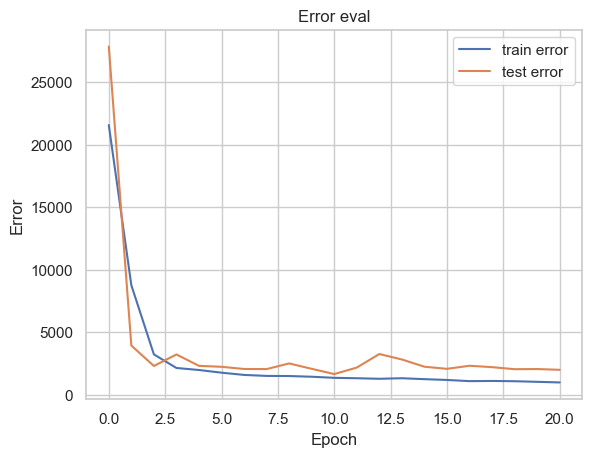

In [94]:
plot_history(history)

165/165 ━━━━━━━━━━━━━━━━━━━━ 73s 434ms/step 
110/110 ━━━━━━━━━━━━━━━━━━━━ 46s 416ms/step
The GRU with OPTUNA model MSE: 1658.1510009765625
The GRU with OPTUNA model MAE: 29.830888748168945


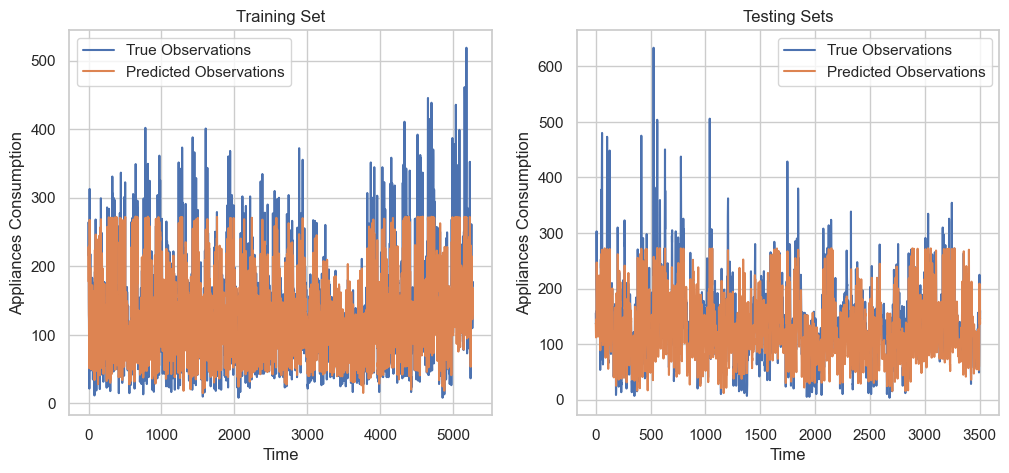

In [95]:
MSE_GRU_FT, MAE_GRU_FT = TrainTestPlot(X_train_seq, X_test_seq, y_test_seq, y_train_seq, best_modelGRU, 'GRU with OPTUNA', NN=False)

165/165 ━━━━━━━━━━━━━━━━━━━━ 72s 434ms/step 
110/110 ━━━━━━━━━━━━━━━━━━━━ 49s 443ms/step


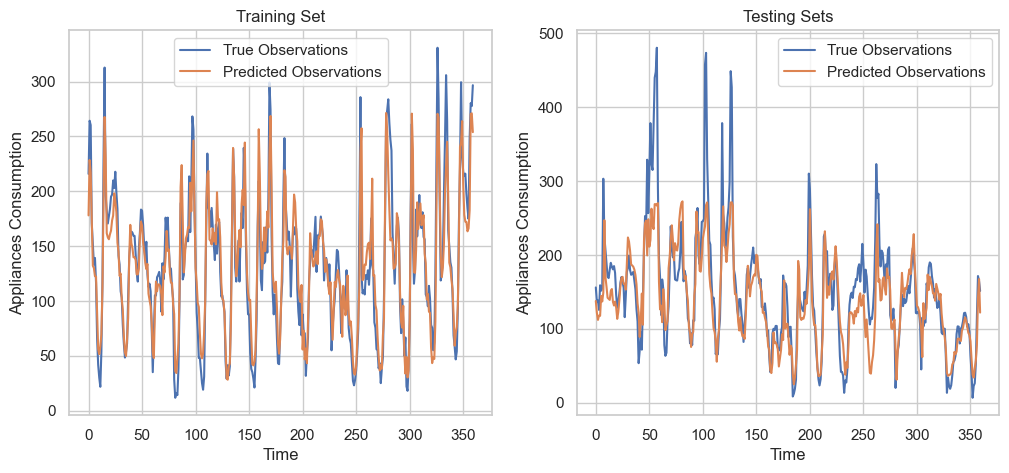

0

In [96]:
TrainTestPlot_360h(X_train_seq, X_test_seq, y_test_seq, y_train_seq, best_modelGRU, 'GRU with OPTUNA', NN=False)

### 首先，由于数据结构发生了新的变化，维度的增加导致模型的训练周期变长，从而增加了计算需求。这迫使我们放弃对超参数的过度优化。尽管如此，我们观察到错误率显著降低，预测区间也明显扩大。因此，模型的精度得到了提升。

### Tout d'abord, en raison des nouveaux changements apportés à la structure des données, l'augmentation de la dimensionnalité a entraîné des cycles d'entraînement du modèle plus longs, ce qui a accru les besoins en calcul. Cela nous a contraints à abandonner l'optimisation excessive des hyperparamètres. Néanmoins, nous avons observé une réduction substantielle des taux d'erreur ainsi qu'une expansion marquée des intervalles de prédiction. Par conséquent, la précision du modèle a améliorée.